In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import time
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/AML_Final_report')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [ ]:
train.dtypes

id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object

# Num columns

In [ ]:
train.budget = train.budget.replace(0,np.nan)
test.budget = test.budget.replace(0,np.nan)

train.budget = train.budget.apply(lambda x: np.log(x))
test.budget = test.budget.apply(lambda x: np.log(x))

train.revenue = train.revenue.apply(lambda x: np.log(x))

train.runtime.fillna(list(train.runtime.describe())[1], inplace = True)
test.runtime.fillna(list(test.runtime.describe())[1], inplace = True)
train.budget.fillna(list(train.budget.describe())[1], inplace = True)
test.budget.fillna(list(test.budget.describe())[1], inplace = True)

In [ ]:
y = train.revenue

In [ ]:
train.drop(columns=['id', 'belongs_to_collection', 'homepage', 'tagline', 'poster_path', 'imdb_id', 'original_title', 'title', 'revenue'], inplace=True)
test.drop(columns=['id', 'belongs_to_collection', 'homepage', 'tagline', 'poster_path', 'imdb_id', 'original_title', 'title'], inplace=True)

## Data Preprocessing

### Dictionary Columns

In [ ]:
def json_change(k):
    if type(k) == str:
        return ast.literal_eval(k)
    else:
        return k

In [ ]:
# Correcting the format of dictionary columns
dic_cols = ['genres', 'production_companies', 'production_countries',
            'spoken_languages', 'Keywords', 'cast', 'crew']

for c in dic_cols:
    train[c] = train[c].apply(lambda x: json_change(x))
    test[c] = test[c].apply(lambda x: json_change(x))

In [ ]:
train

,budget,genres,original_language,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,cast,crew
0,16.454568,"[{'id': 35, 'name': 'Comedy'}]",en,"When Lou, who has become the ""father of the In...",6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de..."
1,17.504390,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,Mia Thermopolis is now a college graduate and ...,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de..."
2,15.009433,"[{'id': 18, 'name': 'Drama'}]",en,"Under the direction of a ruthless instructor, ...",64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de..."
3,13.997832,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de..."
4,16.284763,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",ko,Marine Boy is the story of a former national s...,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,16.284763,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",en,Military men Rock Reilly and Eddie Devane are ...,9.853270,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",4/22/94,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'id': 378, 'name': 'prison'}, {'id': 572, 'n...","[{'cast_id': 2, 'character': 'Rock Reilly', 'c...","[{'credit_id': '52fe4494c3a368484e02ac7d', 'de..."
2996,16.284763,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",sv,Three girls in 1980s Stockholm decide to form ...,3.727996,"[{'name': 'Memfis Film', 'id': 321}, {'name': ...","[{'iso_3166_1': 'DK', 'name': 'Denmark'}, {'is...",3/28/13,102.0,"[{'iso_639_1': 'sv', 'name': 'svenska'}]",Released,"[{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...","[{'cast_id': 5, 'character': 'Bobo', 'credit_i...","[{'credit_id': '5716b72ac3a3686678012c84', 'de..."
2997,17.989898,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",en,"Samantha Caine, suburban homemaker, is the ide...",14.482345,"[{'name': 'New Line Cinema', 'id': 12}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/11/96,120.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'id': 441, 'name': 'assassination'}, {'id': ...","[{'cast_id': 10, 'character': 'Samantha Caine ...","[{'credit_id': '52fe443a9251416c7502d579', 'de..."
2998,17.553180,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",en,Reuben Feffer is a guy who's spent his entire ...,15.725542,"[{'name': 'Jersey Films', 'id': 216}, {'name':...","[{'iso_3166_1': 'US', 'name': 'United States o...",1/16/04,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'id': 966, 'name': 'beach'}, {'id': 2676,

In [ ]:
# Creating lists out of dictionary
from tqdm.auto import tqdm

train['character'] = '0'
test['character'] = '0'
for c in dic_cols:
    # Dev data
    for i in range(len(train)):
        temp = []
        character = []
        name = []
        try:
            for dic in train[c].iloc[i]:
                if c == 'production_countries':
                    temp.append(dic['iso_3166_1'])
                elif c == 'spoken_languages':
                    temp.append(dic['iso_639_1'])
                elif c == 'cast':
                    character.append(dic['character'])
                    temp.append(dic['name'])
                else:
                    temp.append(dic['name'])
            train[c].iloc[i] = temp
            if c == 'cast':
                train['character'].iloc[i] = character
        except:
            continue
    
    # test data
    for i in range(len(test)):
        temp = []
        character = []
        name = []
        try:
            for dic in test[c].iloc[i]:
                if c == 'production_countries':
                    temp.append(dic['iso_3166_1'])
                elif c == 'spoken_languages':
                    temp.append(dic['iso_639_1'])
                elif c == 'cast':
                    character.append(dic['character'])
                    temp.append(dic['name'])
                else:
                    temp.append(dic['name'])
            test[c].iloc[i] = temp
            if c == 'cast':
                test['character'].iloc[i] = character
        except:
            continue

/Users/Abhimanyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
train

,budget,genres,original_language,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,cast,crew,character
0,16.454568,[Comedy],en,"When Lou, who has become the ""father of the In...",6.575393,"[Paramount Pictures, United Artists, Metro-Gol...",[US],2/20/15,93.0,[en],Released,"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...","[Kelly Cantley, Steve Pink, Josh Heald, Josh H...","[Lou, Nick, Jacob, Adam Jr., Hot Tub Repairman..."
1,17.504390,"[Comedy, Drama, Family, Romance]",en,Mia Thermopolis is now a college graduate and ...,8.248895,[Walt Disney Pictures],[US],8/6/04,113.0,[en],Released,"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...","[Garry Marshall, Charles Minsky, John Debney, ...","[Mia Thermopolis, Queen Clarisse Renaldi, Joe,..."
2,15.009433,[Drama],en,"Under the direction of a ruthless instructor, ...",64.299990,"[Bold Films, Blumhouse Productions, Right of W...",[US],10/10/14,105.0,[en],Released,"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...","[Terri Taylor, Richard Henderson, Jeffrey Stot...","[Andrew Neimann, Terence Fletcher, Nicole, Rya..."
3,13.997832,"[Thriller, Drama]",hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,NaN,[IN],3/9/12,122.0,"[en, hi]",Released,"[mystery, bollywood, police corruption, crime,...","[Vidya Balan, Nawazuddin Siddiqui, Parambrata ...","[Sujoy Ghosh, Sujoy Ghosh, Sujoy Ghosh]","[Vidya Bagchi, , , , , , ]"
4,16.284763,"[Action, Thriller]",ko,Marine Boy is the story of a former national s...,1.148070,NaN,[KR],2/5/09,118.0,[ko],Released,NaN,"[Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...","[Jong-seok Yoon, Jong-seok Yoon]","[Chun-soo, Company president Kang, Yu-ri, Comp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,16.284763,"[Comedy, Romance]",en,Military men Rock Reilly and Eddie Devane are ...,9.853270,"[Warner Bros., Morgan Creek Productions]",[US],4/22/94,102.0,[en],Released,"[prison, sex, handcuffs, waitress, fight, fire...","[Tom Berenger, William McNamara, –≠—Ä–∏–∫–∞ –≠...","[Dennis Hopper, Joe Batteer, John Rice, Joe Ba...","[Rock Reilly, Eddie Devane, Toni Johnson, Howa..."
2996,16.284763,"[Drama, Music]",sv,Three girls in 1980s Stockholm decide to form ...,3.727996,"[Memfis Film, Film i Väst]","[DK, SE]",3/28/13,102.0,[sv],Released,"[sweden, punk, based on comic, all girl band, ...","[Mira Barkhammar, Mira Grosin, Liv LeMoyne, Da...","[Imor Hermann, Anna Anthony, Lukas Moodysson, ...","[Bobo, Klara, Hedvig, Klaras pappa, Kenneth, R..."
2997,17.989898,"[Crime, Action, Mystery, Thriller]",en,"Samantha Caine, suburban homemaker, is the ide...",14.482345,"[New Line Cinema, Forge, The Steve Tisch Company]",[US],10/11/96,120.0,[en],Released,"[assassination, amnesia, hostage, chase, dark ...","[Geena Davis, Samuel L. Jackson, Yvonne Zima, ...","[Renny Harlin, Shane Black, Stephanie Austin, ...","[Samantha Caine / Charly Baltimore, Mitch Hene..."
2998,17.553180,"[Comedy, Romance]",en,Reuben Feffer is a guy who's spent his entire ...,15.725542,"[Jersey Films, Loofah Productions]",[US],1/16/04,90.0,[en],Released,"[beach, honeymoon, bride, chance, risk, relati...","[Ben Stiller, Jennifer Aniston, Philip Seymour...","[Danny DeVito, Seamus McGarvey, Nick Moore, Th...","[Reuben Feffer, Polly Prince, Sandy Lyle, Lisa..."


### Date Columns

In [ ]:
for i in range(len(train)):
    date = train.release_date.iloc[i].split('/')
    if int(date[2]) >= 20:
        to_fill = date[0]+'/'+date[1]+'/19'+date[2]
        train.release_date.iloc[i] = to_fill
    else:
        to_fill = date[0]+'/'+date[1]+'/20'+date[2]
        train.release_date.iloc[i] = to_fill

for i in range(len(test)):
    try:
        date = test.release_date.iloc[i].split('/')
        if int(date[2]) >= 20:
            to_fill = date[0]+'/'+date[1]+'/19'+date[2]
            test.release_date.iloc[i] = to_fill
        else:
            to_fill = date[0]+'/'+date[1]+'/20'+date[2]
            test.release_date.iloc[i] = to_fill
    except:
        continue

/Users/Abhimanyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
from datetime import datetime

train.release_date = pd.to_datetime(train.release_date)
test.release_date = pd.to_datetime(test.release_date)
reference = datetime(2020,1,1)

In [ ]:
train['days_since_release'] = (reference - train.release_date).dt.days
test['days_since_release'] = (reference - test.release_date).dt.days

In [ ]:
train['weekday'] = 0
train['day'] = 0
train['month'] = 0
train['year'] = 0

test['weekday'] = 0
test['day'] = 0
test['month'] = 0
test['year'] = 0

for i in range(len(train)):
    train['weekday'].iloc[i] = train.release_date[i].weekday()
    train['day'].iloc[i] = train.release_date[i].day
    train['month'].iloc[i] = train.release_date[i].month
    train['year'].iloc[i] = train.release_date[i].year
    
    
for i in range(len(test)):
    test['weekday'].iloc[i] = test.release_date[i].weekday()
    test['day'].iloc[i] = test.release_date[i].day
    test['month'].iloc[i] = test.release_date[i].month
    test['year'].iloc[i] = test.release_date[i].year

In [ ]:
train = train.drop(columns=['release_date'])
test = test.drop(columns=['release_date'])

In [ ]:
train.weekday = train.weekday.astype("category")
test.weekday = test.weekday.astype("category")

train.day = train.day.astype("category")
test.day = test.day.astype("category")

train.month = train.month.astype("category")
test.month = test.month.astype("category")

In [ ]:
train

,budget,genres,original_language,overview,popularity,production_companies,production_countries,runtime,spoken_languages,status,Keywords,cast,crew,character,days_since_release,weekday,day,month,year
0,16.454568,[Comedy],en,"When Lou, who has become the ""father of the In...",6.575393,"[Paramount Pictures, United Artists, Metro-Gol...",[US],93.0,[en],Released,"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...","[Kelly Cantley, Steve Pink, Josh Heald, Josh H...","[Lou, Nick, Jacob, Adam Jr., Hot Tub Repairman...",1776,4,20,2,2015
1,17.504390,"[Comedy, Drama, Family, Romance]",en,Mia Thermopolis is now a college graduate and ...,8.248895,[Walt Disney Pictures],[US],113.0,[en],Released,"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...","[Garry Marshall, Charles Minsky, John Debney, ...","[Mia Thermopolis, Queen Clarisse Renaldi, Joe,...",5626,4,6,8,2004
2,15.009433,[Drama],en,"Under the direction of a ruthless instructor, ...",64.299990,"[Bold Films, Blumhouse Productions, Right of W...",[US],105.0,[en],Released,"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...","[Terri Taylor, Richard Henderson, Jeffrey Stot...","[Andrew Neimann, Terence Fletcher, Nicole, Rya...",1909,4,10,10,2014
3,13.997832,"[Thriller, Drama]",hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,NaN,[IN],122.0,"[en, hi]",Released,"[mystery, bollywood, police corruption, crime,...","[Vidya Balan, Nawazuddin Siddiqui, Parambrata ...","[Sujoy Ghosh, Sujoy Ghosh, Sujoy Ghosh]","[Vidya Bagchi, , , , , , ]",2854,4,9,3,2012
4,16.284763,"[Action, Thriller]",ko,Marine Boy is the story of a former national s...,1.148070,NaN,[KR],118.0,[ko],Released,NaN,"[Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...","[Jong-seok Yoon, Jong-seok Yoon]","[Chun-soo, Company president Kang, Yu-ri, Comp...",3982,3,5,2,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,16.284763,"[Comedy, Romance]",en,Military men Rock Reilly and Eddie Devane are ...,9.853270,"[Warner Bros., Morgan Creek Productions]",[US],102.0,[en],Released,"[prison, sex, handcuffs, waitress, fight, fire...","[Tom Berenger, William McNamara, –≠—Ä–∏–∫–∞ –≠...","[Dennis Hopper, Joe Batteer, John Rice, Joe Ba...","[Rock Reilly, Eddie Devane, Toni Johnson, Howa...",9385,4,22,4,1994
2996,16.284763,"[Drama, Music]",sv,Three girls in 1980s Stockholm decide to form ...,3.727996,"[Memfis Film, Film i Väst]","[DK, SE]",102.0,[sv],Released,"[sweden, punk, based on comic, all girl band, ...","[Mira Barkhammar, Mira Grosin, Liv LeMoyne, Da...","[Imor Hermann, Anna Anthony, Lukas Moodysson, ...","[Bobo, Klara, Hedvig, Klaras pappa, Kenneth, R...",2470,3,28,3,2013
2997,17.989898,"[Crime, Action, Mystery, Thriller]",en,"Samantha Caine, suburban homemaker, is the ide...",14.482345,"[New Line Cinema, Forge, The Steve Tisch Company]",[US],120.0,[en],Released,"[assassination, amnesia, hostage, chase, dark ...","[Geena Davis, Samuel L. Jackson, Yvonne Zima, ...","[Renny Harlin, Shane Black, Stephanie Austin, ...","[Samantha Caine / Charly Baltimore, Mitch Hene...",8482,4,11,10,1996
2998,17.553180,"[Comedy, Romance]",en,Reuben Feffer is a guy who's spent his entire ...,15.725542,"[Jersey Films, Loofah Productions]",[US],90.0,[en],Released,"[beach, honeymoon, bride, chance, risk, relati...","[Ben Stiller, Jennifer Aniston, Philip Seymour...","[Danny DeVito, Seamus McGarvey, Nick Moore, Th...","[Reuben Feffer, Polly Prince, Sandy Lyle, Lisa...",5829,4,16,1,2004


### Additional Feature Engineering

In [ ]:
train['no_genres'] = 0 
train['no_companies'] = 0 
train['no_actors'] = 0
train['no_keywords'] = 0
train['no_countries'] = 0
train['no_crew'] = 0


for i in range(len(train)):
    try:
        train.no_genres.iloc[i] = len(train.genres.iloc[i])
    except:
        pass
    try:
        train.no_companies.iloc[i] = len(train.production_companies.iloc[i])
    except:
        pass
    try:
        train.no_actors.iloc[i] = len(train.cast.iloc[i])
    except:
        pass
    try:
        train.no_keywords.iloc[i] = len(train.Keywords.iloc[i])
    except:
        pass
    try:
        train.no_countries.iloc[i] = len(train.production_countries.iloc[i])
    except:
        pass
    try:
        train.no_crew.iloc[i] = len(train.crew.iloc[i])
    except:
        pass


test['no_genres'] = 0 
test['no_companies'] = 0 
test['no_actors'] = 0
test['no_keywords'] = 0
test['no_countries'] = 0
test['no_crew'] = 0
    
    
for i in range(len(test)):
    try:
        test.no_genres.iloc[i] = len(test.genres.iloc[i])
    except:
        pass
    try:
        test.no_companies.iloc[i] = len(test.production_companies.iloc[i])
    except:
        pass
    try:
        test.no_actors.iloc[i] = len(test.cast.iloc[i])
    except:
        pass
    try:
        test.no_keywords.iloc[i] = len(test.Keywords.iloc[i])
    except:
        pass
    try:
        test.no_countries.iloc[i] = len(test.production_countries.iloc[i])
    except:
        pass
    try:
        test.no_crew.iloc[i] = len(test.crew.iloc[i])
    except:
        pass

/Users/Abhimanyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
train

,budget,genres,original_language,overview,popularity,production_companies,production_countries,runtime,spoken_languages,status,...,weekday,day,month,year,no_genres,no_companies,no_actors,no_keywords,no_countries,no_crew
0,16.454568,[Comedy],en,"When Lou, who has become the ""father of the In...",6.575393,"[Paramount Pictures, United Artists, Metro-Gol...",[US],93.0,[en],Released,...,4,20,2,2015,1,3,24,4,1,72
1,17.504390,"[Comedy, Drama, Family, Romance]",en,Mia Thermopolis is now a college graduate and ...,8.248895,[Walt Disney Pictures],[US],113.0,[en],Released,...,4,6,8,2004,4,1,20,4,1,9
2,15.009433,[Drama],en,"Under the direction of a ruthless instructor, ...",64.299990,"[Bold Films, Blumhouse Productions, Right of W...",[US],105.0,[en],Released,...,4,10,10,2014,1,3,51,12,1,64
3,13.997832,"[Thriller, Drama]",hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,NaN,[IN],122.0,"[en, hi]",Released,...,4,9,3,2012,2,0,7,7,1,3
4,16.284763,"[Action, Thriller]",ko,Marine Boy is the story of a former national s...,1.148070,NaN,[KR],118.0,[ko],Released,...,3,5,2,2009,2,0,4,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,16.284763,"[Comedy, Romance]",en,Military men Rock Reilly and Eddie Devane are ...,9.853270,"[Warner Bros., Morgan Creek Productions]",[US],102.0,[en],Released,...,4,22,4,1994,2,2,15,19,1,17
2996,16.284763,"[Drama, Music]",sv,Three girls in 1980s Stockholm decide to form ...,3.727996,"[Memfis Film, Film i Väst]","[DK, SE]",102.0,[sv],Released,...,3,28,3,2013,2,2,11,6,2,15
2997,17.989898,"[Crime, Action, Mystery, Thriller]",en,"Samantha Caine, suburban homemaker, is the ide...",14.482345,"[New Line Cinema, Forge, The Steve Tisch Company]",[US],120.0,[en],Released,...,4,11,10,1996,4,3,15,14,1,10
2998,17.553180,"[Comedy, Romance]",en,Reuben Feffer is a guy who's spent his entire ...,15.725542,"[Jersey Films, Loofah Productions]",[US],90.0,[en],Released,...,4,16,1,2004,2,2,26,22,1,89


## Text Data

In [ ]:
# Build the corpus of the "overview"
corpus = 'corpus.txt'
with open(corpus, 'w', encoding = 'utf-8') as outfile:
    for i in range(train.shape[0]):
        line = train.iloc[i]['overview']
        outfile.write(str(line))
        outfile.write("\n")
    for i in range(test.shape[0]):
        line = test.iloc[i]['overview']
        outfile.write(str(line))
        outfile.write("\n")
outfile.close()

In [ ]:
from gensim.models import Word2Vec
def w2v(corpus_sents, save, dim, window, sg, hs, negative, min_count, workers):
    '''
    sg ({0, 1}) – Training algorithm: 1 for skip-gram; otherwise CBOW.
    hs ({0, 1}) – If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
    negative (int) – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
    min_count (int) – Ignores all words with total frequency lower than this.
    workers (int) – Use these many worker threads to train the model (=faster training with multicore machines).'''
    model = Word2Vec(corpus_sents, sg=sg, hs=hs, vector_size=dim, window=window, negative = negative, min_count=min_count, workers=workers)
    model.wv.save(save)
    print('Word2vec with window = ' + str(window) + ', dim = ' + str(dim))

In [ ]:
from gensim.models import KeyedVectors
from scipy.spatial import distance
import string

corpus_sents = [x.translate(str.maketrans('', '', string.punctuation)).strip().split() for x in open(corpus, 'r', encoding = 'utf-8').readlines()]
dim = 20
window = 2
sg = 1
hs = 0
save = str(window) + '-' + str(dim) + '-' + str(sg) + '-' + str(hs) + '.vec'
w2v(corpus_sents, save, dim, window, sg, hs, negative = 10, min_count = 1, workers = 4)
file_name = "2-20-1-0"
w2v = KeyedVectors.load(file_name + ".vec", mmap='r')

with open('vocab.txt', 'w', encoding = 'utf-8') as outfile:
    for i in range(len(w2v.index_to_key)):
        line = w2v.index_to_key[i]
        outfile.write(str(line))
        outfile.write("\n")
outfile.close()

vocab = []
lines = open("vocab.txt", 'r', encoding = 'utf-8').readlines()
for l in lines:
    vocab.append(l.strip("\n"))

model = {}
for i in range(len(vocab)):
    model[vocab[i]] = w2v[vocab[i]]

out = open("2-20-1-0" + ".txt", 'w', encoding = 'utf-8')
for v in vocab:
    if v in w2v.index_to_key:
        out.write(v)
        for x in model[v]:
            out.write(' ' + str(x))
        out.write('\n')
out.close()

Word2vec with window = 2, dim = 20


In [ ]:
def get_X(sample, word_emb, word_emb_size):
    x_t = np.zeros(word_emb_size)
    for word in sample:
        word = word.lower()
        if word in word_emb:
            x_t += word_emb[word]
    if len(sample) > 0:
        x_t /= len(sample)
    return x_t

def load_vec(path, word_emb_size):
    wv = {}
    with open(path,'r',encoding='utf8') as fr:
        for i, line in enumerate(fr):
            data = line.strip().split()
            if len(data) == word_emb_size+1:
                v = np.zeros((word_emb_size,),dtype='float32')
                for j in range(word_emb_size):
                    v[j] = float(data[j+1])
                wv[data[0].lower()] = v
    return wv

In [ ]:
for i in range(dim):
    train['overview_' + str(i)] = 0.0
word_to_embeddings = load_vec('2-20-1-0' + ".txt", dim)
for i in range(train.shape[0]):
    overview = train.iloc[i]['overview']
    if type(overview) == str:
        words = overview.translate(str.maketrans('', '', string.punctuation)).strip().split()
        sentence_embedding = get_X(words, word_to_embeddings, dim)
        for j in range(dim):
            train['overview_' + str(j)].iloc[i] = sentence_embedding[j]

/Users/Abhimanyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
train

,budget,genres,original_language,overview,popularity,production_companies,production_countries,runtime,spoken_languages,status,...,overview_10,overview_11,overview_12,overview_13,overview_14,overview_15,overview_16,overview_17,overview_18,overview_19
0,16.454568,[Comedy],en,"When Lou, who has become the ""father of the In...",6.575393,"[Paramount Pictures, United Artists, Metro-Gol...",[US],93.0,[en],Released,...,0.546743,-0.142243,0.029038,-0.069165,0.402384,0.319116,0.652761,-0.338989,-0.319070,-0.499835
1,17.504390,"[Comedy, Drama, Family, Romance]",en,Mia Thermopolis is now a college graduate and ...,8.248895,[Walt Disney Pictures],[US],113.0,[en],Released,...,0.633360,-0.228507,0.136912,0.024017,0.441822,0.290582,0.852466,-0.252124,-0.305541,-0.392426
2,15.009433,[Drama],en,"Under the direction of a ruthless instructor, ...",64.299990,"[Bold Films, Blumhouse Productions, Right of W...",[US],105.0,[en],Released,...,0.506421,-0.238439,0.122457,-0.010623,0.370803,0.288135,0.637872,-0.381591,-0.320809,-0.329297
3,13.997832,"[Thriller, Drama]",hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,NaN,[IN],122.0,"[en, hi]",Released,...,0.532764,-0.196071,0.107827,0.022821,0.468692,0.264884,0.800678,-0.268917,-0.322265,-0.324329
4,16.284763,"[Action, Thriller]",ko,Marine Boy is the story of a former national s...,1.148070,NaN,[KR],118.0,[ko],Released,...,0.544131,-0.301139,0.103939,-0.001988,0.434339,0.288416,0.637258,-0.460955,-0.390156,-0.366510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,16.284763,"[Comedy, Romance]",en,Military men Rock Reilly and Eddie Devane are ...,9.853270,"[Warner Bros., Morgan Creek Productions]",[US],102.0,[en],Released,...,0.604335,-0.211085,0.121789,0.014884,0.430369,0.293227,0.688049,-0.327472,-0.367388,-0.392798
2996,16.284763,"[Drama, Music]",sv,Three girls in 1980s Stockholm decide to form ...,3.727996,"[Memfis Film, Film i Väst]","[DK, SE]",102.0,[sv],Released,...,0.493841,-0.162080,0.106825,-0.013382,0.433779,0.296529,0.615809,-0.313733,-0.293978,-0.384666
2997,17.989898,"[Crime, Action, Mystery, Thriller]",en,"Samantha Caine, suburban homemaker, is the ide...",14.482345,"[New Line Cinema, Forge, The Steve Tisch Company]",[US],120.0,[en],Released,...,0.552284,-0.230324,0.134825,0.038021,0.412074,0.327063,0.685565,-0.326364,-0.326737,-0.322917
2998,17.553180,"[Comedy, Romance]",en,Reuben Feffer is a guy who's spent his entire ...,15.725542,"[Jersey Films, Loofah Productions]",[US],90.0,[en],Released,...,0.547509,-0.179031,0.078740,-0.031072,0.397865,0.284793,0.660486,-0.328682,-0.317438,-0.324618


In [ ]:
for i in range(dim):
    test['overview_' + str(i)] = 0.0
word_to_embeddings = load_vec('2-20-1-0' + ".txt", dim)
for i in range(test.shape[0]):
    overview = test.iloc[i]['overview']
    if type(overview) == str:
        words = overview.translate(str.maketrans('', '', string.punctuation)).strip().split()
        sentence_embedding = get_X(words, word_to_embeddings, dim)
        for j in range(dim):
            test['overview_' + str(j)].iloc[i] = sentence_embedding[j]

/Users/Abhimanyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
test

,budget,genres,original_language,overview,popularity,production_companies,production_countries,runtime,spoken_languages,status,...,overview_10,overview_11,overview_12,overview_13,overview_14,overview_15,overview_16,overview_17,overview_18,overview_19
0,16.256171,"[Adventure, Animation, Family, Fantasy]",ja,Ash and friends (this time accompanied by newc...,3.851534,NaN,"[JP, US]",90.0,"[en, ja]",Released,...,0.545296,-0.164237,0.065882,-0.023373,0.418766,0.316524,0.629002,-0.363387,-0.324359,-0.417512
1,11.385092,"[Horror, Science Fiction]",en,When an abused wife grows to giant size becaus...,3.559789,[Woolner Brothers Pictures Inc.],[US],65.0,[en],Released,...,0.624813,-0.199839,0.097934,-0.006151,0.451518,0.259221,0.757352,-0.282304,-0.415104,-0.287137
2,16.256171,"[Comedy, Romance]",en,Good-natured astronomer Sam is devastated when...,8.085194,"[Warner Bros., Outlaw Productions (I), Miramax]",[US],100.0,[en],Released,...,0.527175,-0.204407,0.093400,-0.006426,0.390583,0.269465,0.758076,-0.237064,-0.341600,-0.328808
3,15.732433,"[Drama, War, Mystery]",fr,A mother's last wishes send twins Jeanne and S...,8.596012,"[TS Productions, Micro scope, Phi Group]","[CA, FR]",130.0,"[fr, ar, en]",Released,...,0.461941,-0.167529,0.073244,-0.037259,0.399713,0.308525,0.528628,-0.353062,-0.309702,-0.403414
4,14.508658,"[History, Documentary]",en,"In 1972, a seemingly typical shoestring budget...",3.217680,NaN,[US],92.0,[en],Released,...,0.562983,-0.176050,0.096054,0.033135,0.429363,0.297415,0.668342,-0.366998,-0.291132,-0.464042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,17.553180,[Thriller],en,A young man is plunged into a life of subterfu...,9.970359,"[Intermedia Films, DiNovi Pictures, Epsilon Mo...","[FR, US]",118.0,"[en, de, ja, la, es]",Released,...,0.511699,-0.222105,0.137580,-0.023033,0.336560,0.318275,0.611726,-0.451389,-0.343468,-0.279218
4394,16.759950,"[Action, Adventure, Comedy, Thriller]",en,"Three friends, whose lives have been drifting ...",6.046516,"[Paramount Pictures, De Line Pictures]",[US],95.0,[en],Released,...,0.559987,-0.136950,0.062030,-0.017039,0.413680,0.259465,0.744823,-0.326131,-0.336145,-0.330613
4395,16.588099,[Drama],en,"Frank Galvin is a down-on-his luck lawyer, red...",9.596883,[Twentieth Century Fox Film Corporation],[US],129.0,[en],Released,...,0.579434,-0.223760,0.090778,-0.011609,0.382138,0.251536,0.740364,-0.341093,-0.358506,-0.310913
4396,14.508658,"[Horror, Thriller]",en,"For 19-year-old Jay, fall should be about scho...",20.359336,"[Northern Lights Films, Animal Kingdom, Two Fl...",[US],100.0,[en],Released,...,0.596607,-0.222359,0.129047,0.015627,0.412710,0.257135,0.755983,-0.314509,-0.314600,-0.396567


In [ ]:
train.drop(columns=['overview'],inplace=True)
test.drop(columns=['overview'],inplace=True)

## Categorical Columns

In [ ]:
features_choose_top_20 = ['Keywords', 'cast', 'crew', 'character', 'production_companies', 'production_countries', 'spoken_languages']
for feature_name in tqdm(features_choose_top_20):
    features_total = []
    for i in range(train.shape[0]):
        features = train.iloc[i][feature_name]
        if type(features) == list:
            for feature in features:
                if feature not in features_total:
                    features_total.append(feature)
    for i in range(test.shape[0]):
        features = test.iloc[i][feature_name]
        if type(features) == list:
            for feature in features:
                if feature not in features_total:
                    features_total.append(feature)
    print(feature_name)
    print(len(features_total))
    dict_features = {}
    for feature in features_total:
        dict_features[feature] = 0
    for i in range(train.shape[0]):
        features = train.iloc[i][feature_name]
        if type(features) == list:
            for feature in features:
                dict_features[feature] += 1
    for i in range(test.shape[0]):
        features = test.iloc[i][feature_name]
        if type(features) == list:
            for feature in features:
                dict_features[feature] += 1
    lis = sorted(dict_features.items(), key=lambda item: item[1], reverse = True)[:20]
    print(lis)
    for j in range(20):
        train[feature_name + '_' + lis[j][0]] = 0
    for i in range(train.shape[0]):
        for j in range(20):
            if type(train.iloc[i][feature_name]) == list:
                if lis[j][0] in train.iloc[i][feature_name]:
                    train[feature_name + '_' + lis[j][0]].iloc[i] = 1
    for j in range(20):
        test[feature_name + '_' + lis[j][0]] = 0
    for i in range(test.shape[0]):
        for j in range(20):
            if type(test.iloc[i][feature_name]) == list:
                if lis[j][0] in test.iloc[i][feature_name]:
                    test[feature_name + '_' + lis[j][0]].iloc[i] = 1
    train.drop(columns = [feature_name],inplace=True)
    test.drop(columns = [feature_name],inplace=True)

Keywords
11930
[('woman director', 457), ('independent film', 384), ('duringcreditsstinger', 350), ('based on novel', 312), ('murder', 305), ('violence', 245), ('love', 190), ('revenge', 188), ('sex', 186), ('aftercreditsstinger', 183), ('biography', 176), ('sport', 175), ('friendship', 168), ('dystopia', 166), ('police', 160), ('suspense', 159), ('sequel', 158), ('nudity', 153), ('musical', 147), ('teenager', 145)]
cast
75944
[('Samuel L. Jackson', 80), ('Robert De Niro', 71), ('Bruce Willis', 62), ('Morgan Freeman', 61), ('Liam Neeson', 57), ('Willem Dafoe', 55), ('Steve Buscemi', 55), ('Sylvester Stallone', 54), ('Nicolas Cage', 54), ('Matt Damon', 51), ('J.K. Simmons', 50), ('John Goodman', 50), ('Julianne Moore', 50), ('Christopher Walken', 50), ('Robin Williams', 50), ('Johnny Depp', 48), ('Stanley Tucci', 47), ('Harrison Ford', 46), ('Richard Jenkins', 46), ('Ben Stiller', 46)]
crew
68763
[('Avy Kaufman', 105), ('Steven Spielberg', 104), ('Robert Rodriguez', 100), ('Mary Vernieu

In [ ]:
train

,budget,genres,original_language,popularity,runtime,status,days_since_release,weekday,day,month,...,spoken_languages_pt,spoken_languages_cn,spoken_languages_ko,spoken_languages_pl,spoken_languages_la,spoken_languages_hu,spoken_languages_cs,spoken_languages_th,spoken_languages_ta,spoken_languages_sv
0,16.454568,[Comedy],en,6.575393,93.0,Released,1776,4,20,2,...,0,0,0,0,0,0,0,0,0,0
1,17.504390,"[Comedy, Drama, Family, Romance]",en,8.248895,113.0,Released,5626,4,6,8,...,0,0,0,0,0,0,0,0,0,0
2,15.009433,[Drama],en,64.299990,105.0,Released,1909,4,10,10,...,0,0,0,0,0,0,0,0,0,0
3,13.997832,"[Thriller, Drama]",hi,3.174936,122.0,Released,2854,4,9,3,...,0,0,0,0,0,0,0,0,0,0
4,16.284763,"[Action, Thriller]",ko,1.148070,118.0,Released,3982,3,5,2,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,16.284763,"[Comedy, Romance]",en,9.853270,102.0,Released,9385,4,22,4,...,0,0,0,0,0,0,0,0,0,0
2996,16.284763,"[Drama, Music]",sv,3.727996,102.0,Released,2470,3,28,3,...,0,0,0,0,0,0,0,0,0,1
2997,17.989898,"[Crime, Action, Mystery, Thriller]",en,14.482345,120.0,Released,8482,4,11,10,...,0,0,0,0,0,0,0,0,0,0
2998,17.553180,"[Comedy, Romance]",en,15.725542,90.0,Released,5829,4,16,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test

,budget,genres,original_language,popularity,runtime,status,days_since_release,weekday,day,month,...,spoken_languages_pt,spoken_languages_cn,spoken_languages_ko,spoken_languages_pl,spoken_languages_la,spoken_languages_hu,spoken_languages_cs,spoken_languages_th,spoken_languages_ta,spoken_languages_sv
0,16.256171,"[Adventure, Animation, Family, Fantasy]",ja,3.851534,90.0,Released,4554.0,5.0,14.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,11.385092,"[Horror, Science Fiction]",en,3.559789,65.0,Released,22507.0,0.0,19.0,5.0,...,0,0,0,0,0,0,0,0,0,0
2,16.256171,"[Comedy, Romance]",en,8.085194,100.0,Released,8258.0,4.0,23.0,5.0,...,0,0,0,0,0,0,0,0,0,0
3,15.732433,"[Drama, War, Mystery]",fr,8.596012,130.0,Released,3406.0,5.0,4.0,9.0,...,0,0,0,0,0,0,0,0,0,0
4,14.508658,"[History, Documentary]",en,3.217680,92.0,Released,5437.0,4.0,11.0,2.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,17.553180,[Thriller],en,9.970359,118.0,Released,6725.0,4.0,3.0,8.0,...,0,0,0,0,1,0,0,0,0,0
4394,16.759950,"[Action, Adventure, Comedy, Thriller]",en,6.046516,95.0,Released,5612.0,4.0,20.0,8.0,...,0,0,0,0,0,0,0,0,0,0
4395,16.588099,[Drama],en,9.596883,129.0,Released,13538.0,2.0,8.0,12.0,...,0,0,0,0,0,0,0,0,0,0
4396,14.508658,"[Horror, Thriller]",en,20.359336,100.0,Released,1792.0,2.0,4.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# single_category = ['original_language', 'status']
# for feature_name in single_category:
#     ohe = OneHotEncoder(handle_unknown='ignore')
#     train_transformed = ohe.fit_transform(np.array(train[feature_name]).reshape(-1,1)).toarray()
#     test_transformed = ohe.transform(np.array(test[feature_name]).reshape(-1,1)).toarray()

#     train_data = pd.DataFrame(train_transformed,columns=ohe.get_feature_names_out())
#     test_data = pd.DataFrame(test_transformed,columns=ohe.get_feature_names_out())

#     train = pd.concat([train, train_data], axis = 1)
#     test = pd.concat([test, test_data], axis = 1)
    
#     train.drop(columns = [feature_name],inplace=True)
#     test.drop(columns = [feature_name],inplace=True)

In [ ]:
# train

In [ ]:
# test

In [ ]:
several_category = ['genres']

for feature_name in several_category:
    features_total = []
    for i in range(train.shape[0]):
        features = train.iloc[i][feature_name]
        if type(features) == list:
            for feature in features:
                if feature not in features_total:
                    features_total.append(feature)
    for i in range(test.shape[0]):
        features = test.iloc[i][feature_name]
        if type(features) == list:
            for feature in features:
                if feature not in features_total:
                    features_total.append(feature)
    print(feature_name)
    print(len(features_total))
    
    for j in range(len(features_total)):
        train[feature_name + '_' + features_total[j]] = 0
    for i in range(train.shape[0]):
        for j in range(len(features_total)):
            if type(train.iloc[i][feature_name]) == list:
                if features_total[j] in train.iloc[i][feature_name]:
                    train[feature_name + '_' + features_total[j]].iloc[i] = 1
    for j in range(len(features_total)):
        test[feature_name + '_' + features_total[j]] = 0
    for i in range(test.shape[0]):
        for j in range(len(features_total)):
            if type(test.iloc[i][feature_name]) == list:
                if features_total[j] in test.iloc[i][feature_name]:
                    test[feature_name + '_' + features_total[j]].iloc[i] = 1
    train.drop(columns = [feature_name],inplace=True)
    test.drop(columns = [feature_name],inplace=True)

genres
20


/Users/Abhimanyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
train

,budget,original_language,popularity,runtime,status,days_since_release,weekday,day,month,year,...,genres_Music,genres_Crime,genres_Science Fiction,genres_Mystery,genres_Foreign,genres_Fantasy,genres_War,genres_Western,genres_History,genres_TV Movie
0,16.454568,en,6.575393,93.0,Released,1776,4,20,2,2015,...,0,0,0,0,0,0,0,0,0,0
1,17.504390,en,8.248895,113.0,Released,5626,4,6,8,2004,...,0,0,0,0,0,0,0,0,0,0
2,15.009433,en,64.299990,105.0,Released,1909,4,10,10,2014,...,0,0,0,0,0,0,0,0,0,0
3,13.997832,hi,3.174936,122.0,Released,2854,4,9,3,2012,...,0,0,0,0,0,0,0,0,0,0
4,16.284763,ko,1.148070,118.0,Released,3982,3,5,2,2009,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,16.284763,en,9.853270,102.0,Released,9385,4,22,4,1994,...,0,0,0,0,0,0,0,0,0,0
2996,16.284763,sv,3.727996,102.0,Released,2470,3,28,3,2013,...,1,0,0,0,0,0,0,0,0,0
2997,17.989898,en,14.482345,120.0,Released,8482,4,11,10,1996,...,0,1,0,1,0,0,0,0,0,0
2998,17.553180,en,15.725542,90.0,Released,5829,4,16,1,2004,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test

,budget,original_language,popularity,runtime,status,days_since_release,weekday,day,month,year,...,genres_Music,genres_Crime,genres_Science Fiction,genres_Mystery,genres_Foreign,genres_Fantasy,genres_War,genres_Western,genres_History,genres_TV Movie
0,16.256171,ja,3.851534,90.0,Released,4554.0,5.0,14.0,7.0,2007.0,...,0,0,0,0,0,1,0,0,0,0
1,11.385092,en,3.559789,65.0,Released,22507.0,0.0,19.0,5.0,1958.0,...,0,0,1,0,0,0,0,0,0,0
2,16.256171,en,8.085194,100.0,Released,8258.0,4.0,23.0,5.0,1997.0,...,0,0,0,0,0,0,0,0,0,0
3,15.732433,fr,8.596012,130.0,Released,3406.0,5.0,4.0,9.0,2010.0,...,0,0,0,1,0,0,1,0,0,0
4,14.508658,en,3.217680,92.0,Released,5437.0,4.0,11.0,2.0,2005.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,17.553180,en,9.970359,118.0,Released,6725.0,4.0,3.0,8.0,2001.0,...,0,0,0,0,0,0,0,0,0,0
4394,16.759950,en,6.046516,95.0,Released,5612.0,4.0,20.0,8.0,2004.0,...,0,0,0,0,0,0,0,0,0,0
4395,16.588099,en,9.596883,129.0,Released,13538.0,2.0,8.0,12.0,1982.0,...,0,0,0,0,0,0,0,0,0,0
4396,14.508658,en,20.359336,100.0,Released,1792.0,2.0,4.0,2.0,2015.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.to_csv('processed_train_without_ohe.csv',index=False)
test.to_csv('processed_test_without_ohe.csv',index=False)

## Models

In [ ]:
# train = pd.read_csv('processed_train.csv')
# train.drop(columns = ['Unnamed: 0'], inplace = True)
# test = pd.read_csv('processed_test.csv')
# test.drop(columns = ['Unnamed: 0'], inplace = True)
# df = pd.read_csv('train.csv')
# y = df.revenue.apply(lambda x: np.log(x))

In [ ]:
train = pd.read_csv('processed_train_without_ohe.csv')
test = pd.read_csv('processed_test_without_ohe.csv')
df = pd.read_csv('train.csv')
y = df.revenue.apply(lambda x: np.log(x))
# y = df.revenue

In [ ]:
train.head()

,budget,original_language,popularity,runtime,status,days_since_release,weekday,day,month,year,...,genres_Music,genres_Crime,genres_Science Fiction,genres_Mystery,genres_Foreign,genres_Fantasy,genres_War,genres_Western,genres_History,genres_TV Movie
0,16.454568,en,6.575393,93.0,Released,1776,4,20,2,2015,...,0,0,0,0,0,0,0,0,0,0
1,17.504390,en,8.248895,113.0,Released,5626,4,6,8,2004,...,0,0,0,0,0,0,0,0,0,0
2,15.009433,en,64.299990,105.0,Released,1909,4,10,10,2014,...,0,0,0,0,0,0,0,0,0,0
3,13.997832,hi,3.174936,122.0,Released,2854,4,9,3,2012,...,0,0,0,0,0,0,0,0,0,0
4,16.284763,ko,1.148070,118.0,Released,3982,3,5,2,2009,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.original_language = train.original_language.astype('category')
train.status = train.status.astype('category')
train.weekday = train.weekday.fillna(train.weekday.value_counts().index[0]).astype(int).astype('category')
train.day = train.day.fillna(train.day.value_counts().index[0]).astype(int).astype('category')
train.month = train.month.fillna(train.month.value_counts().index[0]).astype(int).astype('category')

test.original_language = test.original_language.astype('category')
test.status = test.status.fillna('Rumored')
test.status = test.status.astype('category')
test.weekday = test.weekday.fillna(test.weekday.value_counts().index[0]).astype(int).astype('category')
test.day = test.day.fillna(test.day.value_counts().index[0]).astype(int).astype('category')
test.month = test.month.fillna(test.month.value_counts().index[0]).astype(int).astype('category')

In [ ]:
train.dtypes[:16]

budget                 float64
original_language     category
popularity             float64
runtime                float64
status                category
days_since_release       int64
weekday               category
day                   category
month                 category
year                     int64
no_genres                int64
no_companies             int64
no_actors                int64
no_keywords              int64
no_countries             int64
no_crew                  int64
dtype: object

In [ ]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor()
lgbm = LGBMRegressor()

In [ ]:
k=10
kf = KFold(n_splits=k,
            shuffle=True,
            random_state=int(time.time()))

list_of_train_index = []
list_of_valid_index = []

for train_index, valid_index in kf.split(np.zeros(len(y)), # Placeholder (dummy input)
                                          y): # True input
    
    list_of_train_index.append(train_index)
    list_of_valid_index.append(valid_index)

In [ ]:
len(list_of_valid_index[0])

300

In [ ]:
cat_cols = ['original_language','status','weekday','day','month']

preds_train = np.zeros([len(train),k])
preds_val = np.zeros([len(list_of_valid_index[0]),k])
preds_test = np.zeros([len(test),k])

log_rmse_train = []
log_rmse_val = []

feature_imps = np.zeros([train.shape[1],k])

for j in tqdm(range(k)):   
    x_train = train.loc[list_of_train_index[j], :]
    x_valid = train.loc[list_of_valid_index[j], :]
    
    y_true_train = y[list_of_train_index[j]]
    y_true_valid = y[list_of_valid_index[j]]

    #cat.fit(x_train,y_true_train,cat_features=cat_cols)
    lgbm.fit(x_train,y_true_train)
    preds_train[:,j] = lgbm.predict(train)
    preds_val[:,j] = lgbm.predict(x_valid)
    preds_test[:,j] = lgbm.predict(test)
    
    #feature_imps[:,j] = cat.feature_importances_
    
    log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
    log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))



In [ ]:
log_rmse_train

[1.0298578515113752,
 1.0114427677686941,
 0.9773985685804479,
 1.0296019702400376,
 1.0191538362462296,
 0.9541838749790358,
 1.0556824858233336,
 0.9836523381807175,
 0.9858038144053027,
 1.0110630669473566]

In [ ]:
log_rmse_val

[2.2908676061526396,
 2.189241819954951,
 1.9845495758354472,
 2.252873459400604,
 2.2043026964794037,
 1.9328181593608087,
 2.3423910724242236,
 2.0347206725341738,
 1.9694229048180454,
 2.0756399367022635]

In [ ]:
preds_test.mean(axis=1)

array([15.60172975, 12.12035916, 15.83857122, ..., 17.88508174,
       16.02074309, 14.92677069])

In [ ]:
preds = preds_test.mean(axis=1)

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub

,id,revenue
0,3001,1000000
1,3002,1000000
2,3003,1000000
3,3004,1000000
4,3005,1000000
...,...,...
4393,7394,1000000
4394,7395,1000000
4395,7396,1000000
4396,7397,1000000


In [ ]:
sub.revenue = np.exp(preds)
sub.to_csv('subs/sub11.csv',index=False)
sub

,id,revenue
0,3001,1.241793e+06
1,3002,1.291874e+06
2,3003,1.358609e+07
3,3004,9.171615e+06
4,3005,8.059877e+05
...,...,...
4393,7394,4.309546e+07
4394,7395,2.808569e+07
4395,7396,7.941445e+07
4396,7397,1.245358e+07


# Model training on first 36 features

In [ ]:
temp_train = train.iloc[:,:36]
temp_test = test.iloc[:,:36]

In [ ]:
lgbm = LGBMRegressor()

preds_train = np.zeros([len(train),k])
preds_val = np.zeros([len(list_of_valid_index[0]),k])
preds_test = np.zeros([len(test),k])

log_rmse_train = []
log_rmse_val = []

feature_imps = np.zeros([temp_train.shape[1],k])

for j in tqdm(range(k)):   
    x_train = temp_train.loc[list_of_train_index[j], :]
    x_valid = temp_test.loc[list_of_valid_index[j], :]
    
    y_true_train = y[list_of_train_index[j]]
    y_true_valid = y[list_of_valid_index[j]]

    #cat.fit(x_train,y_true_train,cat_features=cat_cols)
    lgbm.fit(x_train.y_true_train)
    preds_train[:,j] = lgbm.predict(temp_train)
    preds_val[:,j] = lgbm.predict(x_valid)
    preds_test[:,j] = lgbm.predict(temp_test)
    
    #feature_imps[:,j] = cat.feature_importances_
    
    log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
    log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))



Learning rate set to 0.046578
0:	learn: 2.9940541	total: 5.67ms	remaining: 5.66s
1:	learn: 2.9437691	total: 10.3ms	remaining: 5.13s
2:	learn: 2.8978594	total: 14.1ms	remaining: 4.68s
3:	learn: 2.8548368	total: 18.1ms	remaining: 4.51s
4:	learn: 2.8146249	total: 21.7ms	remaining: 4.31s
5:	learn: 2.7742456	total: 24.7ms	remaining: 4.09s
6:	learn: 2.7331523	total: 28.3ms	remaining: 4.02s
7:	learn: 2.6958981	total: 31.5ms	remaining: 3.9s
8:	learn: 2.6622473	total: 34.7ms	remaining: 3.82s
9:	learn: 2.6300461	total: 37.6ms	remaining: 3.72s
10:	learn: 2.6030315	total: 40.4ms	remaining: 3.63s
11:	learn: 2.5741760	total: 44.1ms	remaining: 3.63s
12:	learn: 2.5467691	total: 47.6ms	remaining: 3.61s
13:	learn: 2.5229978	total: 51ms	remaining: 3.59s
14:	learn: 2.5025929	total: 54.8ms	remaining: 3.6s
15:	learn: 2.4814636	total: 58.3ms	remaining: 3.58s
16:	learn: 2.4598371	total: 61.6ms	remaining: 3.56s
17:	learn: 2.4400219	total: 64.7ms	remaining: 3.53s
18:	learn: 2.4244231	total: 67.9ms	remaining: 3.

173:	learn: 1.8298837	total: 582ms	remaining: 2.76s
174:	learn: 1.8285123	total: 585ms	remaining: 2.76s
175:	learn: 1.8244539	total: 588ms	remaining: 2.75s
176:	learn: 1.8222832	total: 591ms	remaining: 2.75s
177:	learn: 1.8194581	total: 595ms	remaining: 2.75s
178:	learn: 1.8180270	total: 601ms	remaining: 2.76s
179:	learn: 1.8163761	total: 607ms	remaining: 2.76s
180:	learn: 1.8146684	total: 610ms	remaining: 2.76s
181:	learn: 1.8124355	total: 614ms	remaining: 2.76s
182:	learn: 1.8115808	total: 617ms	remaining: 2.75s
183:	learn: 1.8105177	total: 620ms	remaining: 2.75s
184:	learn: 1.8077153	total: 624ms	remaining: 2.75s
185:	learn: 1.8065219	total: 627ms	remaining: 2.74s
186:	learn: 1.8034993	total: 630ms	remaining: 2.74s
187:	learn: 1.8026422	total: 634ms	remaining: 2.74s
188:	learn: 1.8021407	total: 637ms	remaining: 2.73s
189:	learn: 1.7988113	total: 641ms	remaining: 2.73s
190:	learn: 1.7977108	total: 644ms	remaining: 2.73s
191:	learn: 1.7959442	total: 647ms	remaining: 2.72s
192:	learn: 

345:	learn: 1.5714893	total: 1.15s	remaining: 2.18s
346:	learn: 1.5683163	total: 1.16s	remaining: 2.18s
347:	learn: 1.5674056	total: 1.16s	remaining: 2.17s
348:	learn: 1.5670188	total: 1.16s	remaining: 2.17s
349:	learn: 1.5662861	total: 1.17s	remaining: 2.17s
350:	learn: 1.5658964	total: 1.17s	remaining: 2.16s
351:	learn: 1.5650408	total: 1.17s	remaining: 2.16s
352:	learn: 1.5648087	total: 1.18s	remaining: 2.16s
353:	learn: 1.5644663	total: 1.18s	remaining: 2.15s
354:	learn: 1.5633678	total: 1.18s	remaining: 2.15s
355:	learn: 1.5618385	total: 1.19s	remaining: 2.15s
356:	learn: 1.5604003	total: 1.19s	remaining: 2.15s
357:	learn: 1.5590735	total: 1.19s	remaining: 2.14s
358:	learn: 1.5586393	total: 1.2s	remaining: 2.14s
359:	learn: 1.5570655	total: 1.2s	remaining: 2.14s
360:	learn: 1.5563247	total: 1.21s	remaining: 2.13s
361:	learn: 1.5557085	total: 1.21s	remaining: 2.13s
362:	learn: 1.5551754	total: 1.21s	remaining: 2.13s
363:	learn: 1.5543771	total: 1.22s	remaining: 2.13s
364:	learn: 1.

516:	learn: 1.3779803	total: 1.74s	remaining: 1.62s
517:	learn: 1.3778174	total: 1.74s	remaining: 1.62s
518:	learn: 1.3771668	total: 1.74s	remaining: 1.62s
519:	learn: 1.3764018	total: 1.75s	remaining: 1.61s
520:	learn: 1.3748582	total: 1.75s	remaining: 1.61s
521:	learn: 1.3744447	total: 1.75s	remaining: 1.61s
522:	learn: 1.3736955	total: 1.76s	remaining: 1.6s
523:	learn: 1.3733552	total: 1.76s	remaining: 1.6s
524:	learn: 1.3733164	total: 1.76s	remaining: 1.6s
525:	learn: 1.3722632	total: 1.77s	remaining: 1.59s
526:	learn: 1.3715322	total: 1.77s	remaining: 1.59s
527:	learn: 1.3713858	total: 1.77s	remaining: 1.58s
528:	learn: 1.3698624	total: 1.78s	remaining: 1.58s
529:	learn: 1.3691833	total: 1.78s	remaining: 1.58s
530:	learn: 1.3682717	total: 1.78s	remaining: 1.57s
531:	learn: 1.3671614	total: 1.79s	remaining: 1.57s
532:	learn: 1.3662771	total: 1.79s	remaining: 1.57s
533:	learn: 1.3655071	total: 1.79s	remaining: 1.57s
534:	learn: 1.3653571	total: 1.8s	remaining: 1.56s
535:	learn: 1.36

690:	learn: 1.1952967	total: 2.33s	remaining: 1.04s
691:	learn: 1.1942078	total: 2.33s	remaining: 1.04s
692:	learn: 1.1934460	total: 2.33s	remaining: 1.03s
693:	learn: 1.1928927	total: 2.34s	remaining: 1.03s
694:	learn: 1.1918277	total: 2.34s	remaining: 1.03s
695:	learn: 1.1913501	total: 2.35s	remaining: 1.02s
696:	learn: 1.1895861	total: 2.35s	remaining: 1.02s
697:	learn: 1.1886837	total: 2.35s	remaining: 1.02s
698:	learn: 1.1878476	total: 2.36s	remaining: 1.01s
699:	learn: 1.1869173	total: 2.36s	remaining: 1.01s
700:	learn: 1.1853360	total: 2.36s	remaining: 1.01s
701:	learn: 1.1842078	total: 2.37s	remaining: 1s
702:	learn: 1.1835431	total: 2.37s	remaining: 1s
703:	learn: 1.1830831	total: 2.37s	remaining: 998ms
704:	learn: 1.1818657	total: 2.38s	remaining: 995ms
705:	learn: 1.1814076	total: 2.38s	remaining: 992ms
706:	learn: 1.1807983	total: 2.38s	remaining: 988ms
707:	learn: 1.1797682	total: 2.39s	remaining: 985ms
708:	learn: 1.1784166	total: 2.39s	remaining: 982ms
709:	learn: 1.1772

864:	learn: 1.0402903	total: 2.92s	remaining: 455ms
865:	learn: 1.0391969	total: 2.92s	remaining: 452ms
866:	learn: 1.0382250	total: 2.92s	remaining: 449ms
867:	learn: 1.0377410	total: 2.93s	remaining: 445ms
868:	learn: 1.0371311	total: 2.93s	remaining: 442ms
869:	learn: 1.0367045	total: 2.93s	remaining: 438ms
870:	learn: 1.0362347	total: 2.94s	remaining: 435ms
871:	learn: 1.0357841	total: 2.94s	remaining: 432ms
872:	learn: 1.0342007	total: 2.94s	remaining: 428ms
873:	learn: 1.0336618	total: 2.95s	remaining: 425ms
874:	learn: 1.0328751	total: 2.95s	remaining: 421ms
875:	learn: 1.0318062	total: 2.95s	remaining: 418ms
876:	learn: 1.0310364	total: 2.96s	remaining: 415ms
877:	learn: 1.0301666	total: 2.96s	remaining: 411ms
878:	learn: 1.0299964	total: 2.96s	remaining: 408ms
879:	learn: 1.0293009	total: 2.97s	remaining: 405ms
880:	learn: 1.0289740	total: 2.97s	remaining: 401ms
881:	learn: 1.0285064	total: 2.97s	remaining: 398ms
882:	learn: 1.0277167	total: 2.98s	remaining: 395ms
883:	learn: 

24:	learn: 2.3477003	total: 82ms	remaining: 3.2s
25:	learn: 2.3361926	total: 85.4ms	remaining: 3.2s
26:	learn: 2.3220791	total: 88.7ms	remaining: 3.2s
27:	learn: 2.3129251	total: 92.4ms	remaining: 3.21s
28:	learn: 2.3003672	total: 95.6ms	remaining: 3.2s
29:	learn: 2.2886726	total: 98.8ms	remaining: 3.19s
30:	learn: 2.2781996	total: 102ms	remaining: 3.2s
31:	learn: 2.2679451	total: 105ms	remaining: 3.18s
32:	learn: 2.2610624	total: 108ms	remaining: 3.18s
33:	learn: 2.2526754	total: 111ms	remaining: 3.17s
34:	learn: 2.2442604	total: 115ms	remaining: 3.16s
35:	learn: 2.2357756	total: 118ms	remaining: 3.17s
36:	learn: 2.2277644	total: 122ms	remaining: 3.17s
37:	learn: 2.2210035	total: 125ms	remaining: 3.16s
38:	learn: 2.2135700	total: 128ms	remaining: 3.17s
39:	learn: 2.2051468	total: 132ms	remaining: 3.16s
40:	learn: 2.1989157	total: 135ms	remaining: 3.15s
41:	learn: 2.1943459	total: 137ms	remaining: 3.13s
42:	learn: 2.1873629	total: 141ms	remaining: 3.13s
43:	learn: 2.1817231	total: 144m

197:	learn: 1.8124332	total: 669ms	remaining: 2.71s
198:	learn: 1.8107959	total: 673ms	remaining: 2.71s
199:	learn: 1.8086965	total: 676ms	remaining: 2.7s
200:	learn: 1.8065457	total: 679ms	remaining: 2.7s
201:	learn: 1.8033908	total: 683ms	remaining: 2.7s
202:	learn: 1.8007454	total: 687ms	remaining: 2.69s
203:	learn: 1.7986501	total: 690ms	remaining: 2.69s
204:	learn: 1.7953936	total: 693ms	remaining: 2.69s
205:	learn: 1.7940205	total: 697ms	remaining: 2.69s
206:	learn: 1.7927215	total: 701ms	remaining: 2.68s
207:	learn: 1.7912965	total: 704ms	remaining: 2.68s
208:	learn: 1.7893433	total: 708ms	remaining: 2.68s
209:	learn: 1.7875404	total: 712ms	remaining: 2.68s
210:	learn: 1.7848002	total: 715ms	remaining: 2.67s
211:	learn: 1.7819062	total: 719ms	remaining: 2.67s
212:	learn: 1.7804707	total: 722ms	remaining: 2.67s
213:	learn: 1.7783704	total: 726ms	remaining: 2.67s
214:	learn: 1.7766361	total: 730ms	remaining: 2.66s
215:	learn: 1.7731148	total: 735ms	remaining: 2.67s
216:	learn: 1.7

362:	learn: 1.5596351	total: 1.26s	remaining: 2.21s
363:	learn: 1.5591325	total: 1.26s	remaining: 2.21s
364:	learn: 1.5572137	total: 1.26s	remaining: 2.2s
365:	learn: 1.5542131	total: 1.27s	remaining: 2.2s
366:	learn: 1.5519563	total: 1.27s	remaining: 2.19s
367:	learn: 1.5515631	total: 1.28s	remaining: 2.19s
368:	learn: 1.5505318	total: 1.28s	remaining: 2.19s
369:	learn: 1.5498632	total: 1.28s	remaining: 2.18s
370:	learn: 1.5477318	total: 1.29s	remaining: 2.18s
371:	learn: 1.5466653	total: 1.29s	remaining: 2.18s
372:	learn: 1.5455999	total: 1.29s	remaining: 2.17s
373:	learn: 1.5435697	total: 1.3s	remaining: 2.17s
374:	learn: 1.5409791	total: 1.3s	remaining: 2.17s
375:	learn: 1.5397274	total: 1.3s	remaining: 2.16s
376:	learn: 1.5368553	total: 1.31s	remaining: 2.16s
377:	learn: 1.5348620	total: 1.31s	remaining: 2.15s
378:	learn: 1.5343868	total: 1.31s	remaining: 2.15s
379:	learn: 1.5330746	total: 1.32s	remaining: 2.15s
380:	learn: 1.5319922	total: 1.32s	remaining: 2.15s
381:	learn: 1.529

534:	learn: 1.3615265	total: 1.84s	remaining: 1.6s
535:	learn: 1.3603609	total: 1.84s	remaining: 1.6s
536:	learn: 1.3592181	total: 1.85s	remaining: 1.59s
537:	learn: 1.3584888	total: 1.85s	remaining: 1.59s
538:	learn: 1.3577159	total: 1.85s	remaining: 1.59s
539:	learn: 1.3571506	total: 1.86s	remaining: 1.58s
540:	learn: 1.3566304	total: 1.86s	remaining: 1.58s
541:	learn: 1.3559778	total: 1.87s	remaining: 1.58s
542:	learn: 1.3545259	total: 1.87s	remaining: 1.57s
543:	learn: 1.3542808	total: 1.87s	remaining: 1.57s
544:	learn: 1.3529797	total: 1.88s	remaining: 1.57s
545:	learn: 1.3529236	total: 1.88s	remaining: 1.56s
546:	learn: 1.3522366	total: 1.88s	remaining: 1.56s
547:	learn: 1.3504165	total: 1.89s	remaining: 1.56s
548:	learn: 1.3494400	total: 1.89s	remaining: 1.55s
549:	learn: 1.3487447	total: 1.9s	remaining: 1.55s
550:	learn: 1.3472338	total: 1.9s	remaining: 1.55s
551:	learn: 1.3464299	total: 1.9s	remaining: 1.54s
552:	learn: 1.3458739	total: 1.91s	remaining: 1.54s
553:	learn: 1.344

700:	learn: 1.2090479	total: 2.42s	remaining: 1.03s
701:	learn: 1.2087391	total: 2.43s	remaining: 1.03s
702:	learn: 1.2082685	total: 2.43s	remaining: 1.03s
703:	learn: 1.2069926	total: 2.43s	remaining: 1.02s
704:	learn: 1.2060603	total: 2.44s	remaining: 1.02s
705:	learn: 1.2055245	total: 2.44s	remaining: 1.02s
706:	learn: 1.2048970	total: 2.44s	remaining: 1.01s
707:	learn: 1.2037697	total: 2.45s	remaining: 1.01s
708:	learn: 1.2030007	total: 2.45s	remaining: 1.01s
709:	learn: 1.2016957	total: 2.45s	remaining: 1s
710:	learn: 1.2007263	total: 2.46s	remaining: 999ms
711:	learn: 1.2000804	total: 2.46s	remaining: 996ms
712:	learn: 1.1992611	total: 2.46s	remaining: 992ms
713:	learn: 1.1978296	total: 2.47s	remaining: 988ms
714:	learn: 1.1971756	total: 2.47s	remaining: 985ms
715:	learn: 1.1965989	total: 2.47s	remaining: 981ms
716:	learn: 1.1959404	total: 2.48s	remaining: 978ms
717:	learn: 1.1955763	total: 2.48s	remaining: 974ms
718:	learn: 1.1950554	total: 2.48s	remaining: 971ms
719:	learn: 1.1

868:	learn: 1.0828994	total: 3.01s	remaining: 454ms
869:	learn: 1.0822602	total: 3.02s	remaining: 451ms
870:	learn: 1.0811210	total: 3.02s	remaining: 447ms
871:	learn: 1.0799069	total: 3.02s	remaining: 444ms
872:	learn: 1.0789962	total: 3.03s	remaining: 440ms
873:	learn: 1.0778828	total: 3.03s	remaining: 437ms
874:	learn: 1.0769746	total: 3.03s	remaining: 433ms
875:	learn: 1.0758258	total: 3.04s	remaining: 430ms
876:	learn: 1.0754021	total: 3.04s	remaining: 427ms
877:	learn: 1.0749952	total: 3.04s	remaining: 423ms
878:	learn: 1.0747626	total: 3.05s	remaining: 420ms
879:	learn: 1.0737612	total: 3.05s	remaining: 416ms
880:	learn: 1.0728075	total: 3.05s	remaining: 413ms
881:	learn: 1.0723597	total: 3.06s	remaining: 409ms
882:	learn: 1.0706831	total: 3.06s	remaining: 406ms
883:	learn: 1.0700922	total: 3.07s	remaining: 402ms
884:	learn: 1.0695307	total: 3.07s	remaining: 399ms
885:	learn: 1.0686474	total: 3.07s	remaining: 395ms
886:	learn: 1.0676727	total: 3.08s	remaining: 392ms
887:	learn: 

76:	learn: 2.0467674	total: 261ms	remaining: 3.13s
77:	learn: 2.0443172	total: 264ms	remaining: 3.13s
78:	learn: 2.0405961	total: 268ms	remaining: 3.12s
79:	learn: 2.0371904	total: 271ms	remaining: 3.12s
80:	learn: 2.0352278	total: 274ms	remaining: 3.11s
81:	learn: 2.0314399	total: 278ms	remaining: 3.11s
82:	learn: 2.0293288	total: 280ms	remaining: 3.1s
83:	learn: 2.0246315	total: 284ms	remaining: 3.09s
84:	learn: 2.0213824	total: 287ms	remaining: 3.09s
85:	learn: 2.0183936	total: 291ms	remaining: 3.09s
86:	learn: 2.0177245	total: 294ms	remaining: 3.09s
87:	learn: 2.0135273	total: 297ms	remaining: 3.08s
88:	learn: 2.0126846	total: 301ms	remaining: 3.08s
89:	learn: 2.0107374	total: 303ms	remaining: 3.07s
90:	learn: 2.0087945	total: 307ms	remaining: 3.07s
91:	learn: 2.0069556	total: 311ms	remaining: 3.06s
92:	learn: 2.0052925	total: 313ms	remaining: 3.06s
93:	learn: 2.0033162	total: 316ms	remaining: 3.05s
94:	learn: 1.9979039	total: 319ms	remaining: 3.04s
95:	learn: 1.9961723	total: 323m

251:	learn: 1.7061750	total: 850ms	remaining: 2.52s
252:	learn: 1.7047201	total: 854ms	remaining: 2.52s
253:	learn: 1.7037997	total: 857ms	remaining: 2.52s
254:	learn: 1.7034874	total: 860ms	remaining: 2.51s
255:	learn: 1.7024491	total: 864ms	remaining: 2.51s
256:	learn: 1.7002160	total: 867ms	remaining: 2.51s
257:	learn: 1.6987749	total: 871ms	remaining: 2.5s
258:	learn: 1.6962735	total: 874ms	remaining: 2.5s
259:	learn: 1.6953445	total: 877ms	remaining: 2.5s
260:	learn: 1.6935797	total: 881ms	remaining: 2.5s
261:	learn: 1.6935068	total: 884ms	remaining: 2.49s
262:	learn: 1.6930249	total: 888ms	remaining: 2.49s
263:	learn: 1.6913169	total: 891ms	remaining: 2.48s
264:	learn: 1.6893023	total: 894ms	remaining: 2.48s
265:	learn: 1.6877288	total: 898ms	remaining: 2.48s
266:	learn: 1.6874734	total: 901ms	remaining: 2.47s
267:	learn: 1.6855933	total: 904ms	remaining: 2.47s
268:	learn: 1.6842938	total: 907ms	remaining: 2.46s
269:	learn: 1.6816420	total: 910ms	remaining: 2.46s
270:	learn: 1.68

426:	learn: 1.4841063	total: 1.44s	remaining: 1.93s
427:	learn: 1.4831411	total: 1.44s	remaining: 1.93s
428:	learn: 1.4818008	total: 1.44s	remaining: 1.92s
429:	learn: 1.4804984	total: 1.45s	remaining: 1.92s
430:	learn: 1.4799448	total: 1.45s	remaining: 1.91s
431:	learn: 1.4790825	total: 1.45s	remaining: 1.91s
432:	learn: 1.4775114	total: 1.46s	remaining: 1.91s
433:	learn: 1.4767289	total: 1.46s	remaining: 1.91s
434:	learn: 1.4766644	total: 1.46s	remaining: 1.9s
435:	learn: 1.4748876	total: 1.47s	remaining: 1.9s
436:	learn: 1.4739066	total: 1.47s	remaining: 1.9s
437:	learn: 1.4738749	total: 1.47s	remaining: 1.89s
438:	learn: 1.4722274	total: 1.48s	remaining: 1.89s
439:	learn: 1.4713850	total: 1.48s	remaining: 1.89s
440:	learn: 1.4702704	total: 1.49s	remaining: 1.88s
441:	learn: 1.4688999	total: 1.49s	remaining: 1.88s
442:	learn: 1.4677922	total: 1.49s	remaining: 1.88s
443:	learn: 1.4666478	total: 1.5s	remaining: 1.87s
444:	learn: 1.4661812	total: 1.5s	remaining: 1.87s
445:	learn: 1.465

598:	learn: 1.3018918	total: 2.02s	remaining: 1.36s
599:	learn: 1.3008684	total: 2.03s	remaining: 1.35s
600:	learn: 1.2997670	total: 2.03s	remaining: 1.35s
601:	learn: 1.2977976	total: 2.04s	remaining: 1.35s
602:	learn: 1.2974261	total: 2.04s	remaining: 1.34s
603:	learn: 1.2957629	total: 2.04s	remaining: 1.34s
604:	learn: 1.2949514	total: 2.04s	remaining: 1.33s
605:	learn: 1.2943358	total: 2.05s	remaining: 1.33s
606:	learn: 1.2930936	total: 2.05s	remaining: 1.33s
607:	learn: 1.2917311	total: 2.06s	remaining: 1.32s
608:	learn: 1.2903245	total: 2.06s	remaining: 1.32s
609:	learn: 1.2893908	total: 2.06s	remaining: 1.32s
610:	learn: 1.2893261	total: 2.06s	remaining: 1.31s
611:	learn: 1.2877629	total: 2.07s	remaining: 1.31s
612:	learn: 1.2869610	total: 2.07s	remaining: 1.31s
613:	learn: 1.2857732	total: 2.07s	remaining: 1.3s
614:	learn: 1.2843288	total: 2.08s	remaining: 1.3s
615:	learn: 1.2842723	total: 2.08s	remaining: 1.3s
616:	learn: 1.2825391	total: 2.09s	remaining: 1.29s
617:	learn: 1.2

772:	learn: 1.1404634	total: 2.61s	remaining: 767ms
773:	learn: 1.1395828	total: 2.61s	remaining: 763ms
774:	learn: 1.1381655	total: 2.62s	remaining: 760ms
775:	learn: 1.1372124	total: 2.62s	remaining: 756ms
776:	learn: 1.1369810	total: 2.62s	remaining: 753ms
777:	learn: 1.1362971	total: 2.63s	remaining: 750ms
778:	learn: 1.1354595	total: 2.63s	remaining: 746ms
779:	learn: 1.1349053	total: 2.63s	remaining: 743ms
780:	learn: 1.1345956	total: 2.64s	remaining: 739ms
781:	learn: 1.1338109	total: 2.64s	remaining: 736ms
782:	learn: 1.1325892	total: 2.64s	remaining: 733ms
783:	learn: 1.1317654	total: 2.65s	remaining: 729ms
784:	learn: 1.1303892	total: 2.65s	remaining: 726ms
785:	learn: 1.1296244	total: 2.65s	remaining: 723ms
786:	learn: 1.1284003	total: 2.66s	remaining: 719ms
787:	learn: 1.1277271	total: 2.66s	remaining: 716ms
788:	learn: 1.1263546	total: 2.66s	remaining: 713ms
789:	learn: 1.1256158	total: 2.67s	remaining: 709ms
790:	learn: 1.1252708	total: 2.67s	remaining: 706ms
791:	learn: 

937:	learn: 1.0142598	total: 3.19s	remaining: 211ms
938:	learn: 1.0134126	total: 3.2s	remaining: 208ms
939:	learn: 1.0126530	total: 3.2s	remaining: 204ms
940:	learn: 1.0117276	total: 3.21s	remaining: 201ms
941:	learn: 1.0110583	total: 3.21s	remaining: 198ms
942:	learn: 1.0105156	total: 3.21s	remaining: 194ms
943:	learn: 1.0094591	total: 3.21s	remaining: 191ms
944:	learn: 1.0088703	total: 3.22s	remaining: 187ms
945:	learn: 1.0081050	total: 3.22s	remaining: 184ms
946:	learn: 1.0074083	total: 3.23s	remaining: 181ms
947:	learn: 1.0064441	total: 3.23s	remaining: 177ms
948:	learn: 1.0056868	total: 3.23s	remaining: 174ms
949:	learn: 1.0048609	total: 3.23s	remaining: 170ms
950:	learn: 1.0047737	total: 3.24s	remaining: 167ms
951:	learn: 1.0041045	total: 3.24s	remaining: 163ms
952:	learn: 1.0033415	total: 3.25s	remaining: 160ms
953:	learn: 1.0025029	total: 3.25s	remaining: 157ms
954:	learn: 1.0018394	total: 3.25s	remaining: 153ms
955:	learn: 1.0013254	total: 3.26s	remaining: 150ms
956:	learn: 1.

157:	learn: 1.8674231	total: 509ms	remaining: 2.71s
158:	learn: 1.8658425	total: 513ms	remaining: 2.71s
159:	learn: 1.8640043	total: 517ms	remaining: 2.71s
160:	learn: 1.8622051	total: 521ms	remaining: 2.72s
161:	learn: 1.8615988	total: 524ms	remaining: 2.71s
162:	learn: 1.8595987	total: 528ms	remaining: 2.71s
163:	learn: 1.8579033	total: 531ms	remaining: 2.71s
164:	learn: 1.8565559	total: 534ms	remaining: 2.7s
165:	learn: 1.8555952	total: 537ms	remaining: 2.7s
166:	learn: 1.8550643	total: 541ms	remaining: 2.7s
167:	learn: 1.8533664	total: 545ms	remaining: 2.7s
168:	learn: 1.8515085	total: 548ms	remaining: 2.69s
169:	learn: 1.8514914	total: 549ms	remaining: 2.68s
170:	learn: 1.8513586	total: 552ms	remaining: 2.68s
171:	learn: 1.8492751	total: 556ms	remaining: 2.67s
172:	learn: 1.8482648	total: 559ms	remaining: 2.67s
173:	learn: 1.8478482	total: 562ms	remaining: 2.67s
174:	learn: 1.8457470	total: 565ms	remaining: 2.66s
175:	learn: 1.8427082	total: 568ms	remaining: 2.66s
176:	learn: 1.84

328:	learn: 1.6359805	total: 1.08s	remaining: 2.2s
329:	learn: 1.6338347	total: 1.08s	remaining: 2.19s
330:	learn: 1.6318515	total: 1.08s	remaining: 2.19s
331:	learn: 1.6311387	total: 1.09s	remaining: 2.19s
332:	learn: 1.6291756	total: 1.09s	remaining: 2.18s
333:	learn: 1.6266603	total: 1.09s	remaining: 2.18s
334:	learn: 1.6245902	total: 1.1s	remaining: 2.17s
335:	learn: 1.6241013	total: 1.1s	remaining: 2.17s
336:	learn: 1.6227044	total: 1.1s	remaining: 2.17s
337:	learn: 1.6211141	total: 1.1s	remaining: 2.17s
338:	learn: 1.6199321	total: 1.11s	remaining: 2.16s
339:	learn: 1.6184861	total: 1.11s	remaining: 2.16s
340:	learn: 1.6172724	total: 1.12s	remaining: 2.16s
341:	learn: 1.6154907	total: 1.12s	remaining: 2.15s
342:	learn: 1.6131619	total: 1.12s	remaining: 2.15s
343:	learn: 1.6115856	total: 1.13s	remaining: 2.15s
344:	learn: 1.6096871	total: 1.13s	remaining: 2.14s
345:	learn: 1.6078428	total: 1.13s	remaining: 2.14s
346:	learn: 1.6076864	total: 1.13s	remaining: 2.13s
347:	learn: 1.605

505:	learn: 1.4172245	total: 1.66s	remaining: 1.62s
506:	learn: 1.4160212	total: 1.67s	remaining: 1.62s
507:	learn: 1.4151640	total: 1.67s	remaining: 1.62s
508:	learn: 1.4143748	total: 1.68s	remaining: 1.61s
509:	learn: 1.4127696	total: 1.68s	remaining: 1.61s
510:	learn: 1.4111123	total: 1.68s	remaining: 1.61s
511:	learn: 1.4096250	total: 1.69s	remaining: 1.61s
512:	learn: 1.4087996	total: 1.69s	remaining: 1.6s
513:	learn: 1.4083005	total: 1.69s	remaining: 1.6s
514:	learn: 1.4074552	total: 1.7s	remaining: 1.6s
515:	learn: 1.4057075	total: 1.7s	remaining: 1.59s
516:	learn: 1.4048969	total: 1.71s	remaining: 1.59s
517:	learn: 1.4035927	total: 1.71s	remaining: 1.59s
518:	learn: 1.4019186	total: 1.71s	remaining: 1.59s
519:	learn: 1.4002405	total: 1.72s	remaining: 1.58s
520:	learn: 1.3991268	total: 1.72s	remaining: 1.58s
521:	learn: 1.3974633	total: 1.72s	remaining: 1.58s
522:	learn: 1.3964691	total: 1.73s	remaining: 1.57s
523:	learn: 1.3953276	total: 1.73s	remaining: 1.57s
524:	learn: 1.394

672:	learn: 1.2313205	total: 2.25s	remaining: 1.09s
673:	learn: 1.2305715	total: 2.25s	remaining: 1.09s
674:	learn: 1.2293990	total: 2.25s	remaining: 1.09s
675:	learn: 1.2291901	total: 2.26s	remaining: 1.08s
676:	learn: 1.2288742	total: 2.26s	remaining: 1.08s
677:	learn: 1.2267455	total: 2.27s	remaining: 1.07s
678:	learn: 1.2257773	total: 2.27s	remaining: 1.07s
679:	learn: 1.2250275	total: 2.27s	remaining: 1.07s
680:	learn: 1.2234673	total: 2.27s	remaining: 1.07s
681:	learn: 1.2229703	total: 2.28s	remaining: 1.06s
682:	learn: 1.2221792	total: 2.28s	remaining: 1.06s
683:	learn: 1.2216599	total: 2.29s	remaining: 1.05s
684:	learn: 1.2208613	total: 2.29s	remaining: 1.05s
685:	learn: 1.2199668	total: 2.29s	remaining: 1.05s
686:	learn: 1.2195369	total: 2.29s	remaining: 1.04s
687:	learn: 1.2188851	total: 2.3s	remaining: 1.04s
688:	learn: 1.2176530	total: 2.3s	remaining: 1.04s
689:	learn: 1.2163723	total: 2.31s	remaining: 1.03s
690:	learn: 1.2151027	total: 2.31s	remaining: 1.03s
691:	learn: 1.

841:	learn: 1.0839510	total: 2.82s	remaining: 530ms
842:	learn: 1.0834600	total: 2.83s	remaining: 527ms
843:	learn: 1.0827631	total: 2.83s	remaining: 523ms
844:	learn: 1.0823113	total: 2.83s	remaining: 520ms
845:	learn: 1.0816468	total: 2.84s	remaining: 517ms
846:	learn: 1.0814105	total: 2.84s	remaining: 513ms
847:	learn: 1.0804285	total: 2.84s	remaining: 510ms
848:	learn: 1.0797214	total: 2.85s	remaining: 506ms
849:	learn: 1.0792574	total: 2.85s	remaining: 503ms
850:	learn: 1.0787271	total: 2.85s	remaining: 500ms
851:	learn: 1.0781573	total: 2.86s	remaining: 496ms
852:	learn: 1.0776461	total: 2.86s	remaining: 493ms
853:	learn: 1.0768464	total: 2.86s	remaining: 490ms
854:	learn: 1.0762238	total: 2.87s	remaining: 486ms
855:	learn: 1.0750583	total: 2.87s	remaining: 483ms
856:	learn: 1.0744994	total: 2.87s	remaining: 480ms
857:	learn: 1.0735258	total: 2.88s	remaining: 476ms
858:	learn: 1.0729348	total: 2.88s	remaining: 473ms
859:	learn: 1.0721173	total: 2.88s	remaining: 469ms
860:	learn: 

Learning rate set to 0.046578
0:	learn: 2.9955651	total: 3.71ms	remaining: 3.71s
1:	learn: 2.9445576	total: 7.22ms	remaining: 3.6s
2:	learn: 2.8981005	total: 10.5ms	remaining: 3.47s
3:	learn: 2.8540822	total: 13.5ms	remaining: 3.35s
4:	learn: 2.8129452	total: 16.4ms	remaining: 3.27s
5:	learn: 2.7726755	total: 19.4ms	remaining: 3.22s
6:	learn: 2.7318092	total: 22.8ms	remaining: 3.23s
7:	learn: 2.6986281	total: 25.7ms	remaining: 3.18s
8:	learn: 2.6663067	total: 28.8ms	remaining: 3.17s
9:	learn: 2.6355344	total: 32ms	remaining: 3.17s
10:	learn: 2.6101862	total: 35.4ms	remaining: 3.18s
11:	learn: 2.5822348	total: 38.6ms	remaining: 3.18s
12:	learn: 2.5538814	total: 41.7ms	remaining: 3.16s
13:	learn: 2.5313021	total: 45.1ms	remaining: 3.17s
14:	learn: 2.5096457	total: 48.7ms	remaining: 3.2s
15:	learn: 2.4881822	total: 52.3ms	remaining: 3.21s
16:	learn: 2.4706617	total: 55.7ms	remaining: 3.22s
17:	learn: 2.4509225	total: 59.8ms	remaining: 3.26s
18:	learn: 2.4337476	total: 63.3ms	remaining: 3.

177:	learn: 1.8249999	total: 586ms	remaining: 2.71s
178:	learn: 1.8239327	total: 589ms	remaining: 2.7s
179:	learn: 1.8207758	total: 593ms	remaining: 2.7s
180:	learn: 1.8191807	total: 596ms	remaining: 2.7s
181:	learn: 1.8159872	total: 600ms	remaining: 2.7s
182:	learn: 1.8146109	total: 603ms	remaining: 2.69s
183:	learn: 1.8129940	total: 607ms	remaining: 2.69s
184:	learn: 1.8096147	total: 610ms	remaining: 2.69s
185:	learn: 1.8083818	total: 613ms	remaining: 2.68s
186:	learn: 1.8049749	total: 617ms	remaining: 2.68s
187:	learn: 1.8046734	total: 621ms	remaining: 2.68s
188:	learn: 1.8035795	total: 624ms	remaining: 2.68s
189:	learn: 1.8020151	total: 628ms	remaining: 2.67s
190:	learn: 1.7976977	total: 631ms	remaining: 2.67s
191:	learn: 1.7967968	total: 634ms	remaining: 2.67s
192:	learn: 1.7960044	total: 638ms	remaining: 2.67s
193:	learn: 1.7951158	total: 641ms	remaining: 2.66s
194:	learn: 1.7943709	total: 644ms	remaining: 2.66s
195:	learn: 1.7937759	total: 647ms	remaining: 2.65s
196:	learn: 1.79

350:	learn: 1.5743572	total: 1.17s	remaining: 2.17s
351:	learn: 1.5729880	total: 1.17s	remaining: 2.16s
352:	learn: 1.5719784	total: 1.18s	remaining: 2.16s
353:	learn: 1.5704900	total: 1.18s	remaining: 2.16s
354:	learn: 1.5704135	total: 1.18s	remaining: 2.15s
355:	learn: 1.5679972	total: 1.19s	remaining: 2.15s
356:	learn: 1.5670718	total: 1.19s	remaining: 2.15s
357:	learn: 1.5670025	total: 1.19s	remaining: 2.14s
358:	learn: 1.5656589	total: 1.2s	remaining: 2.14s
359:	learn: 1.5655576	total: 1.2s	remaining: 2.13s
360:	learn: 1.5636830	total: 1.2s	remaining: 2.13s
361:	learn: 1.5636002	total: 1.21s	remaining: 2.13s
362:	learn: 1.5625219	total: 1.21s	remaining: 2.12s
363:	learn: 1.5623650	total: 1.21s	remaining: 2.12s
364:	learn: 1.5595700	total: 1.22s	remaining: 2.12s
365:	learn: 1.5567656	total: 1.22s	remaining: 2.11s
366:	learn: 1.5554995	total: 1.22s	remaining: 2.11s
367:	learn: 1.5543820	total: 1.23s	remaining: 2.11s
368:	learn: 1.5529124	total: 1.23s	remaining: 2.1s
369:	learn: 1.55

521:	learn: 1.3661681	total: 1.76s	remaining: 1.61s
522:	learn: 1.3653896	total: 1.76s	remaining: 1.61s
523:	learn: 1.3635251	total: 1.76s	remaining: 1.6s
524:	learn: 1.3629392	total: 1.77s	remaining: 1.6s
525:	learn: 1.3616870	total: 1.77s	remaining: 1.6s
526:	learn: 1.3602240	total: 1.78s	remaining: 1.59s
527:	learn: 1.3594372	total: 1.78s	remaining: 1.59s
528:	learn: 1.3577228	total: 1.79s	remaining: 1.59s
529:	learn: 1.3562995	total: 1.79s	remaining: 1.59s
530:	learn: 1.3561629	total: 1.8s	remaining: 1.59s
531:	learn: 1.3556863	total: 1.8s	remaining: 1.59s
532:	learn: 1.3537004	total: 1.81s	remaining: 1.58s
533:	learn: 1.3519735	total: 1.81s	remaining: 1.58s
534:	learn: 1.3502422	total: 1.81s	remaining: 1.58s
535:	learn: 1.3496397	total: 1.82s	remaining: 1.57s
536:	learn: 1.3477579	total: 1.82s	remaining: 1.57s
537:	learn: 1.3464259	total: 1.82s	remaining: 1.57s
538:	learn: 1.3452841	total: 1.83s	remaining: 1.56s
539:	learn: 1.3445345	total: 1.83s	remaining: 1.56s
540:	learn: 1.343

686:	learn: 1.1973010	total: 2.34s	remaining: 1.07s
687:	learn: 1.1967184	total: 2.34s	remaining: 1.06s
688:	learn: 1.1960176	total: 2.35s	remaining: 1.06s
689:	learn: 1.1954496	total: 2.35s	remaining: 1.06s
690:	learn: 1.1948642	total: 2.35s	remaining: 1.05s
691:	learn: 1.1933874	total: 2.36s	remaining: 1.05s
692:	learn: 1.1926328	total: 2.36s	remaining: 1.05s
693:	learn: 1.1917155	total: 2.36s	remaining: 1.04s
694:	learn: 1.1912130	total: 2.37s	remaining: 1.04s
695:	learn: 1.1906651	total: 2.37s	remaining: 1.03s
696:	learn: 1.1893371	total: 2.37s	remaining: 1.03s
697:	learn: 1.1891342	total: 2.38s	remaining: 1.03s
698:	learn: 1.1886073	total: 2.38s	remaining: 1.02s
699:	learn: 1.1879712	total: 2.38s	remaining: 1.02s
700:	learn: 1.1869328	total: 2.39s	remaining: 1.02s
701:	learn: 1.1855597	total: 2.39s	remaining: 1.01s
702:	learn: 1.1840771	total: 2.39s	remaining: 1.01s
703:	learn: 1.1830858	total: 2.4s	remaining: 1.01s
704:	learn: 1.1826875	total: 2.4s	remaining: 1s
705:	learn: 1.182

855:	learn: 1.0560076	total: 2.92s	remaining: 492ms
856:	learn: 1.0553191	total: 2.93s	remaining: 489ms
857:	learn: 1.0545555	total: 2.93s	remaining: 485ms
858:	learn: 1.0537941	total: 2.94s	remaining: 482ms
859:	learn: 1.0526609	total: 2.94s	remaining: 479ms
860:	learn: 1.0518836	total: 2.94s	remaining: 475ms
861:	learn: 1.0510960	total: 2.95s	remaining: 472ms
862:	learn: 1.0505332	total: 2.95s	remaining: 469ms
863:	learn: 1.0493369	total: 2.96s	remaining: 465ms
864:	learn: 1.0490100	total: 2.96s	remaining: 462ms
865:	learn: 1.0484077	total: 2.96s	remaining: 459ms
866:	learn: 1.0475039	total: 2.97s	remaining: 455ms
867:	learn: 1.0469024	total: 2.97s	remaining: 452ms
868:	learn: 1.0462621	total: 2.98s	remaining: 448ms
869:	learn: 1.0453216	total: 2.98s	remaining: 445ms
870:	learn: 1.0446276	total: 2.98s	remaining: 442ms
871:	learn: 1.0440303	total: 2.99s	remaining: 438ms
872:	learn: 1.0435758	total: 2.99s	remaining: 435ms
873:	learn: 1.0432518	total: 2.99s	remaining: 432ms
874:	learn: 

68:	learn: 2.0807986	total: 235ms	remaining: 3.18s
69:	learn: 2.0778609	total: 239ms	remaining: 3.17s
70:	learn: 2.0747621	total: 242ms	remaining: 3.17s
71:	learn: 2.0720036	total: 246ms	remaining: 3.17s
72:	learn: 2.0670804	total: 249ms	remaining: 3.16s
73:	learn: 2.0641828	total: 252ms	remaining: 3.15s
74:	learn: 2.0602248	total: 255ms	remaining: 3.15s
75:	learn: 2.0579982	total: 258ms	remaining: 3.14s
76:	learn: 2.0551943	total: 261ms	remaining: 3.13s
77:	learn: 2.0526536	total: 264ms	remaining: 3.12s
78:	learn: 2.0468173	total: 268ms	remaining: 3.12s
79:	learn: 2.0433749	total: 271ms	remaining: 3.12s
80:	learn: 2.0400831	total: 275ms	remaining: 3.12s
81:	learn: 2.0375023	total: 278ms	remaining: 3.12s
82:	learn: 2.0350126	total: 282ms	remaining: 3.11s
83:	learn: 2.0328035	total: 285ms	remaining: 3.1s
84:	learn: 2.0307861	total: 288ms	remaining: 3.1s
85:	learn: 2.0285503	total: 292ms	remaining: 3.1s
86:	learn: 2.0268777	total: 295ms	remaining: 3.1s
87:	learn: 2.0217930	total: 299ms	r

245:	learn: 1.7279691	total: 826ms	remaining: 2.53s
246:	learn: 1.7275597	total: 829ms	remaining: 2.53s
247:	learn: 1.7274626	total: 832ms	remaining: 2.52s
248:	learn: 1.7249378	total: 836ms	remaining: 2.52s
249:	learn: 1.7236215	total: 839ms	remaining: 2.52s
250:	learn: 1.7219888	total: 843ms	remaining: 2.52s
251:	learn: 1.7200390	total: 846ms	remaining: 2.51s
252:	learn: 1.7193682	total: 849ms	remaining: 2.51s
253:	learn: 1.7188541	total: 852ms	remaining: 2.5s
254:	learn: 1.7184610	total: 856ms	remaining: 2.5s
255:	learn: 1.7160639	total: 859ms	remaining: 2.5s
256:	learn: 1.7144029	total: 862ms	remaining: 2.49s
257:	learn: 1.7134119	total: 865ms	remaining: 2.49s
258:	learn: 1.7130274	total: 869ms	remaining: 2.49s
259:	learn: 1.7114880	total: 873ms	remaining: 2.48s
260:	learn: 1.7097032	total: 876ms	remaining: 2.48s
261:	learn: 1.7078042	total: 879ms	remaining: 2.48s
262:	learn: 1.7062017	total: 883ms	remaining: 2.47s
263:	learn: 1.7050414	total: 886ms	remaining: 2.47s
264:	learn: 1.7

416:	learn: 1.5023782	total: 1.4s	remaining: 1.95s
417:	learn: 1.5018369	total: 1.4s	remaining: 1.95s
418:	learn: 1.5017853	total: 1.4s	remaining: 1.94s
419:	learn: 1.5009957	total: 1.41s	remaining: 1.94s
420:	learn: 1.4994283	total: 1.41s	remaining: 1.94s
421:	learn: 1.4973817	total: 1.41s	remaining: 1.94s
422:	learn: 1.4960985	total: 1.42s	remaining: 1.93s
423:	learn: 1.4960096	total: 1.42s	remaining: 1.93s
424:	learn: 1.4951290	total: 1.42s	remaining: 1.93s
425:	learn: 1.4942594	total: 1.43s	remaining: 1.92s
426:	learn: 1.4928430	total: 1.43s	remaining: 1.92s
427:	learn: 1.4907831	total: 1.43s	remaining: 1.92s
428:	learn: 1.4887687	total: 1.44s	remaining: 1.91s
429:	learn: 1.4878169	total: 1.44s	remaining: 1.91s
430:	learn: 1.4869015	total: 1.44s	remaining: 1.91s
431:	learn: 1.4858388	total: 1.45s	remaining: 1.9s
432:	learn: 1.4843075	total: 1.45s	remaining: 1.9s
433:	learn: 1.4827488	total: 1.45s	remaining: 1.9s
434:	learn: 1.4809505	total: 1.46s	remaining: 1.89s
435:	learn: 1.4789

593:	learn: 1.3005397	total: 1.98s	remaining: 1.35s
594:	learn: 1.2997554	total: 1.99s	remaining: 1.35s
595:	learn: 1.2989515	total: 1.99s	remaining: 1.35s
596:	learn: 1.2971177	total: 1.99s	remaining: 1.35s
597:	learn: 1.2960285	total: 2s	remaining: 1.34s
598:	learn: 1.2951344	total: 2s	remaining: 1.34s
599:	learn: 1.2942285	total: 2s	remaining: 1.34s
600:	learn: 1.2926077	total: 2.01s	remaining: 1.33s
601:	learn: 1.2920489	total: 2.01s	remaining: 1.33s
602:	learn: 1.2910898	total: 2.01s	remaining: 1.33s
603:	learn: 1.2887891	total: 2.02s	remaining: 1.32s
604:	learn: 1.2881983	total: 2.02s	remaining: 1.32s
605:	learn: 1.2873805	total: 2.02s	remaining: 1.32s
606:	learn: 1.2861039	total: 2.03s	remaining: 1.31s
607:	learn: 1.2846305	total: 2.03s	remaining: 1.31s
608:	learn: 1.2841232	total: 2.03s	remaining: 1.31s
609:	learn: 1.2838369	total: 2.04s	remaining: 1.3s
610:	learn: 1.2828015	total: 2.04s	remaining: 1.3s
611:	learn: 1.2823814	total: 2.04s	remaining: 1.3s
612:	learn: 1.2807470	to

763:	learn: 1.1410081	total: 2.57s	remaining: 794ms
764:	learn: 1.1397931	total: 2.58s	remaining: 791ms
765:	learn: 1.1389315	total: 2.58s	remaining: 788ms
766:	learn: 1.1383484	total: 2.58s	remaining: 784ms
767:	learn: 1.1375132	total: 2.58s	remaining: 781ms
768:	learn: 1.1374504	total: 2.59s	remaining: 778ms
769:	learn: 1.1369530	total: 2.59s	remaining: 775ms
770:	learn: 1.1357065	total: 2.6s	remaining: 772ms
771:	learn: 1.1352916	total: 2.6s	remaining: 768ms
772:	learn: 1.1344615	total: 2.6s	remaining: 765ms
773:	learn: 1.1341930	total: 2.61s	remaining: 762ms
774:	learn: 1.1330818	total: 2.61s	remaining: 758ms
775:	learn: 1.1321407	total: 2.62s	remaining: 755ms
776:	learn: 1.1317854	total: 2.62s	remaining: 752ms
777:	learn: 1.1308943	total: 2.62s	remaining: 748ms
778:	learn: 1.1298376	total: 2.63s	remaining: 745ms
779:	learn: 1.1291563	total: 2.63s	remaining: 742ms
780:	learn: 1.1276639	total: 2.63s	remaining: 738ms
781:	learn: 1.1275658	total: 2.64s	remaining: 735ms
782:	learn: 1.1

929:	learn: 1.0107534	total: 3.16s	remaining: 238ms
930:	learn: 1.0090740	total: 3.16s	remaining: 234ms
931:	learn: 1.0087061	total: 3.17s	remaining: 231ms
932:	learn: 1.0082449	total: 3.17s	remaining: 228ms
933:	learn: 1.0077727	total: 3.17s	remaining: 224ms
934:	learn: 1.0069090	total: 3.18s	remaining: 221ms
935:	learn: 1.0061087	total: 3.18s	remaining: 218ms
936:	learn: 1.0056185	total: 3.19s	remaining: 214ms
937:	learn: 1.0054339	total: 3.19s	remaining: 211ms
938:	learn: 1.0042079	total: 3.19s	remaining: 208ms
939:	learn: 1.0027925	total: 3.2s	remaining: 204ms
940:	learn: 1.0010887	total: 3.2s	remaining: 201ms
941:	learn: 1.0005513	total: 3.21s	remaining: 197ms
942:	learn: 1.0001151	total: 3.21s	remaining: 194ms
943:	learn: 0.9990205	total: 3.21s	remaining: 191ms
944:	learn: 0.9981822	total: 3.21s	remaining: 187ms
945:	learn: 0.9975957	total: 3.22s	remaining: 184ms
946:	learn: 0.9973892	total: 3.22s	remaining: 180ms
947:	learn: 0.9969083	total: 3.23s	remaining: 177ms
948:	learn: 0.

146:	learn: 1.8853526	total: 494ms	remaining: 2.87s
147:	learn: 1.8852541	total: 497ms	remaining: 2.86s
148:	learn: 1.8844844	total: 501ms	remaining: 2.86s
149:	learn: 1.8829795	total: 504ms	remaining: 2.86s
150:	learn: 1.8829790	total: 505ms	remaining: 2.84s
151:	learn: 1.8797401	total: 509ms	remaining: 2.84s
152:	learn: 1.8770673	total: 512ms	remaining: 2.83s
153:	learn: 1.8733932	total: 515ms	remaining: 2.83s
154:	learn: 1.8718933	total: 519ms	remaining: 2.83s
155:	learn: 1.8708749	total: 523ms	remaining: 2.83s
156:	learn: 1.8688632	total: 526ms	remaining: 2.82s
157:	learn: 1.8670820	total: 530ms	remaining: 2.82s
158:	learn: 1.8649163	total: 533ms	remaining: 2.82s
159:	learn: 1.8631417	total: 536ms	remaining: 2.81s
160:	learn: 1.8618095	total: 539ms	remaining: 2.81s
161:	learn: 1.8599587	total: 543ms	remaining: 2.81s
162:	learn: 1.8584310	total: 546ms	remaining: 2.8s
163:	learn: 1.8547427	total: 550ms	remaining: 2.8s
164:	learn: 1.8530698	total: 553ms	remaining: 2.8s
165:	learn: 1.8

320:	learn: 1.6194651	total: 1.15s	remaining: 2.43s
321:	learn: 1.6178952	total: 1.15s	remaining: 2.43s
322:	learn: 1.6163568	total: 1.16s	remaining: 2.42s
323:	learn: 1.6153313	total: 1.16s	remaining: 2.42s
324:	learn: 1.6128186	total: 1.16s	remaining: 2.42s
325:	learn: 1.6123704	total: 1.17s	remaining: 2.41s
326:	learn: 1.6121099	total: 1.17s	remaining: 2.41s
327:	learn: 1.6103342	total: 1.17s	remaining: 2.4s
328:	learn: 1.6092784	total: 1.18s	remaining: 2.4s
329:	learn: 1.6072299	total: 1.18s	remaining: 2.4s
330:	learn: 1.6063679	total: 1.18s	remaining: 2.39s
331:	learn: 1.6055351	total: 1.19s	remaining: 2.39s
332:	learn: 1.6047674	total: 1.19s	remaining: 2.38s
333:	learn: 1.6028957	total: 1.19s	remaining: 2.38s
334:	learn: 1.6001127	total: 1.2s	remaining: 2.38s
335:	learn: 1.6000616	total: 1.2s	remaining: 2.37s
336:	learn: 1.5992073	total: 1.2s	remaining: 2.37s
337:	learn: 1.5985937	total: 1.21s	remaining: 2.36s
338:	learn: 1.5980389	total: 1.21s	remaining: 2.36s
339:	learn: 1.5969

492:	learn: 1.4073729	total: 1.74s	remaining: 1.79s
493:	learn: 1.4056830	total: 1.74s	remaining: 1.78s
494:	learn: 1.4047827	total: 1.74s	remaining: 1.78s
495:	learn: 1.4037037	total: 1.75s	remaining: 1.78s
496:	learn: 1.4028281	total: 1.75s	remaining: 1.77s
497:	learn: 1.4020406	total: 1.75s	remaining: 1.77s
498:	learn: 1.4003054	total: 1.76s	remaining: 1.76s
499:	learn: 1.3997250	total: 1.76s	remaining: 1.76s
500:	learn: 1.3979984	total: 1.77s	remaining: 1.76s
501:	learn: 1.3979723	total: 1.77s	remaining: 1.76s
502:	learn: 1.3974731	total: 1.77s	remaining: 1.75s
503:	learn: 1.3966788	total: 1.78s	remaining: 1.75s
504:	learn: 1.3949702	total: 1.78s	remaining: 1.74s
505:	learn: 1.3940695	total: 1.78s	remaining: 1.74s
506:	learn: 1.3930577	total: 1.78s	remaining: 1.74s
507:	learn: 1.3927598	total: 1.79s	remaining: 1.73s
508:	learn: 1.3915584	total: 1.79s	remaining: 1.73s
509:	learn: 1.3915187	total: 1.79s	remaining: 1.72s
510:	learn: 1.3914960	total: 1.8s	remaining: 1.72s
511:	learn: 1

657:	learn: 1.2520379	total: 2.32s	remaining: 1.21s
658:	learn: 1.2510982	total: 2.33s	remaining: 1.2s
659:	learn: 1.2508455	total: 2.33s	remaining: 1.2s
660:	learn: 1.2504458	total: 2.33s	remaining: 1.2s
661:	learn: 1.2490244	total: 2.34s	remaining: 1.19s
662:	learn: 1.2489303	total: 2.34s	remaining: 1.19s
663:	learn: 1.2482312	total: 2.34s	remaining: 1.19s
664:	learn: 1.2482135	total: 2.35s	remaining: 1.18s
665:	learn: 1.2467520	total: 2.35s	remaining: 1.18s
666:	learn: 1.2462659	total: 2.35s	remaining: 1.17s
667:	learn: 1.2451808	total: 2.36s	remaining: 1.17s
668:	learn: 1.2428131	total: 2.36s	remaining: 1.17s
669:	learn: 1.2418093	total: 2.36s	remaining: 1.16s
670:	learn: 1.2412225	total: 2.37s	remaining: 1.16s
671:	learn: 1.2404358	total: 2.37s	remaining: 1.16s
672:	learn: 1.2394283	total: 2.37s	remaining: 1.15s
673:	learn: 1.2380501	total: 2.38s	remaining: 1.15s
674:	learn: 1.2368256	total: 2.38s	remaining: 1.15s
675:	learn: 1.2361653	total: 2.38s	remaining: 1.14s
676:	learn: 1.2

824:	learn: 1.1090525	total: 2.91s	remaining: 618ms
825:	learn: 1.1076109	total: 2.92s	remaining: 614ms
826:	learn: 1.1064308	total: 2.92s	remaining: 611ms
827:	learn: 1.1056841	total: 2.92s	remaining: 607ms
828:	learn: 1.1052112	total: 2.93s	remaining: 604ms
829:	learn: 1.1045161	total: 2.93s	remaining: 600ms
830:	learn: 1.1038614	total: 2.93s	remaining: 596ms
831:	learn: 1.1029849	total: 2.94s	remaining: 593ms
832:	learn: 1.1017586	total: 2.94s	remaining: 589ms
833:	learn: 1.1011663	total: 2.94s	remaining: 586ms
834:	learn: 1.1001377	total: 2.94s	remaining: 582ms
835:	learn: 1.0997803	total: 2.95s	remaining: 579ms
836:	learn: 1.0991005	total: 2.95s	remaining: 575ms
837:	learn: 1.0983886	total: 2.96s	remaining: 572ms
838:	learn: 1.0973804	total: 2.96s	remaining: 568ms
839:	learn: 1.0964651	total: 2.96s	remaining: 565ms
840:	learn: 1.0963352	total: 2.97s	remaining: 561ms
841:	learn: 1.0950755	total: 2.97s	remaining: 558ms
842:	learn: 1.0942660	total: 2.97s	remaining: 554ms
843:	learn: 

993:	learn: 0.9790818	total: 3.5s	remaining: 21.1ms
994:	learn: 0.9783812	total: 3.51s	remaining: 17.6ms
995:	learn: 0.9781520	total: 3.51s	remaining: 14.1ms
996:	learn: 0.9774667	total: 3.51s	remaining: 10.6ms
997:	learn: 0.9761807	total: 3.52s	remaining: 7.05ms
998:	learn: 0.9755048	total: 3.52s	remaining: 3.52ms
999:	learn: 0.9743496	total: 3.52s	remaining: 0us
Learning rate set to 0.046578
0:	learn: 3.0482079	total: 3.36ms	remaining: 3.36s
1:	learn: 2.9973810	total: 7.95ms	remaining: 3.97s
2:	learn: 2.9474473	total: 11.5ms	remaining: 3.83s
3:	learn: 2.9009963	total: 14.6ms	remaining: 3.64s
4:	learn: 2.8549654	total: 17.6ms	remaining: 3.5s
5:	learn: 2.8152135	total: 20.4ms	remaining: 3.37s
6:	learn: 2.7744342	total: 23.7ms	remaining: 3.37s
7:	learn: 2.7369565	total: 27.3ms	remaining: 3.38s
8:	learn: 2.7035175	total: 30.3ms	remaining: 3.34s
9:	learn: 2.6707675	total: 33.3ms	remaining: 3.29s
10:	learn: 2.6423537	total: 36.6ms	remaining: 3.29s
11:	learn: 2.6122196	total: 39.9ms	remaini

209:	learn: 1.8026872	total: 713ms	remaining: 2.68s
210:	learn: 1.8022327	total: 717ms	remaining: 2.68s
211:	learn: 1.8017728	total: 721ms	remaining: 2.68s
212:	learn: 1.8002538	total: 724ms	remaining: 2.67s
213:	learn: 1.7980271	total: 728ms	remaining: 2.67s
214:	learn: 1.7976486	total: 731ms	remaining: 2.67s
215:	learn: 1.7946640	total: 734ms	remaining: 2.66s
216:	learn: 1.7938902	total: 738ms	remaining: 2.66s
217:	learn: 1.7905511	total: 741ms	remaining: 2.66s
218:	learn: 1.7904099	total: 745ms	remaining: 2.66s
219:	learn: 1.7901654	total: 748ms	remaining: 2.65s
220:	learn: 1.7883838	total: 752ms	remaining: 2.65s
221:	learn: 1.7857443	total: 755ms	remaining: 2.65s
222:	learn: 1.7837962	total: 758ms	remaining: 2.64s
223:	learn: 1.7820325	total: 762ms	remaining: 2.64s
224:	learn: 1.7797776	total: 765ms	remaining: 2.64s
225:	learn: 1.7789914	total: 769ms	remaining: 2.63s
226:	learn: 1.7782681	total: 772ms	remaining: 2.63s
227:	learn: 1.7764384	total: 775ms	remaining: 2.63s
228:	learn: 

376:	learn: 1.5997888	total: 1.3s	remaining: 2.15s
377:	learn: 1.5977733	total: 1.3s	remaining: 2.14s
378:	learn: 1.5961903	total: 1.31s	remaining: 2.14s
379:	learn: 1.5959683	total: 1.31s	remaining: 2.14s
380:	learn: 1.5944856	total: 1.31s	remaining: 2.13s
381:	learn: 1.5942098	total: 1.32s	remaining: 2.13s
382:	learn: 1.5926491	total: 1.32s	remaining: 2.13s
383:	learn: 1.5912930	total: 1.32s	remaining: 2.12s
384:	learn: 1.5912224	total: 1.33s	remaining: 2.12s
385:	learn: 1.5895653	total: 1.33s	remaining: 2.12s
386:	learn: 1.5877166	total: 1.33s	remaining: 2.11s
387:	learn: 1.5875077	total: 1.34s	remaining: 2.11s
388:	learn: 1.5870673	total: 1.34s	remaining: 2.11s
389:	learn: 1.5849661	total: 1.34s	remaining: 2.1s
390:	learn: 1.5837384	total: 1.35s	remaining: 2.1s
391:	learn: 1.5829591	total: 1.35s	remaining: 2.1s
392:	learn: 1.5823038	total: 1.35s	remaining: 2.09s
393:	learn: 1.5815243	total: 1.36s	remaining: 2.09s
394:	learn: 1.5794541	total: 1.36s	remaining: 2.08s
395:	learn: 1.578

545:	learn: 1.4174947	total: 1.87s	remaining: 1.56s
546:	learn: 1.4160732	total: 1.88s	remaining: 1.55s
547:	learn: 1.4142211	total: 1.88s	remaining: 1.55s
548:	learn: 1.4127894	total: 1.88s	remaining: 1.54s
549:	learn: 1.4118780	total: 1.89s	remaining: 1.54s
550:	learn: 1.4114639	total: 1.89s	remaining: 1.54s
551:	learn: 1.4099130	total: 1.89s	remaining: 1.53s
552:	learn: 1.4087973	total: 1.89s	remaining: 1.53s
553:	learn: 1.4080499	total: 1.9s	remaining: 1.53s
554:	learn: 1.4074925	total: 1.9s	remaining: 1.52s
555:	learn: 1.4069321	total: 1.9s	remaining: 1.52s
556:	learn: 1.4067776	total: 1.91s	remaining: 1.52s
557:	learn: 1.4053982	total: 1.91s	remaining: 1.51s
558:	learn: 1.4046169	total: 1.91s	remaining: 1.51s
559:	learn: 1.4034847	total: 1.92s	remaining: 1.51s
560:	learn: 1.4019613	total: 1.92s	remaining: 1.5s
561:	learn: 1.4008467	total: 1.92s	remaining: 1.5s
562:	learn: 1.4002518	total: 1.93s	remaining: 1.5s
563:	learn: 1.3989729	total: 1.93s	remaining: 1.49s
564:	learn: 1.3988

720:	learn: 1.2498944	total: 2.46s	remaining: 953ms
721:	learn: 1.2485910	total: 2.47s	remaining: 950ms
722:	learn: 1.2475380	total: 2.47s	remaining: 947ms
723:	learn: 1.2467853	total: 2.48s	remaining: 944ms
724:	learn: 1.2460342	total: 2.48s	remaining: 940ms
725:	learn: 1.2451370	total: 2.48s	remaining: 937ms
726:	learn: 1.2439985	total: 2.49s	remaining: 934ms
727:	learn: 1.2426166	total: 2.49s	remaining: 931ms
728:	learn: 1.2420168	total: 2.5s	remaining: 928ms
729:	learn: 1.2413576	total: 2.5s	remaining: 924ms
730:	learn: 1.2396964	total: 2.5s	remaining: 921ms
731:	learn: 1.2390356	total: 2.51s	remaining: 918ms
732:	learn: 1.2378922	total: 2.51s	remaining: 914ms
733:	learn: 1.2364688	total: 2.51s	remaining: 911ms
734:	learn: 1.2360627	total: 2.52s	remaining: 907ms
735:	learn: 1.2336667	total: 2.52s	remaining: 904ms
736:	learn: 1.2335027	total: 2.52s	remaining: 900ms
737:	learn: 1.2320262	total: 2.53s	remaining: 897ms
738:	learn: 1.2317204	total: 2.53s	remaining: 893ms
739:	learn: 1.2

889:	learn: 1.1147323	total: 3.05s	remaining: 377ms
890:	learn: 1.1144998	total: 3.05s	remaining: 373ms
891:	learn: 1.1135092	total: 3.06s	remaining: 370ms
892:	learn: 1.1120560	total: 3.06s	remaining: 367ms
893:	learn: 1.1111344	total: 3.06s	remaining: 363ms
894:	learn: 1.1107539	total: 3.07s	remaining: 360ms
895:	learn: 1.1093788	total: 3.07s	remaining: 356ms
896:	learn: 1.1084655	total: 3.07s	remaining: 353ms
897:	learn: 1.1077464	total: 3.08s	remaining: 350ms
898:	learn: 1.1072659	total: 3.08s	remaining: 346ms
899:	learn: 1.1068452	total: 3.08s	remaining: 343ms
900:	learn: 1.1065163	total: 3.09s	remaining: 339ms
901:	learn: 1.1059619	total: 3.09s	remaining: 336ms
902:	learn: 1.1056614	total: 3.09s	remaining: 332ms
903:	learn: 1.1048104	total: 3.1s	remaining: 329ms
904:	learn: 1.1031840	total: 3.1s	remaining: 326ms
905:	learn: 1.1024235	total: 3.11s	remaining: 322ms
906:	learn: 1.1014179	total: 3.11s	remaining: 319ms
907:	learn: 1.1009234	total: 3.11s	remaining: 315ms
908:	learn: 1.

69:	learn: 2.0699532	total: 235ms	remaining: 3.12s
70:	learn: 2.0669482	total: 238ms	remaining: 3.12s
71:	learn: 2.0642369	total: 242ms	remaining: 3.11s
72:	learn: 2.0609518	total: 245ms	remaining: 3.11s
73:	learn: 2.0584754	total: 249ms	remaining: 3.11s
74:	learn: 2.0554001	total: 252ms	remaining: 3.1s
75:	learn: 2.0526327	total: 255ms	remaining: 3.1s
76:	learn: 2.0489578	total: 259ms	remaining: 3.1s
77:	learn: 2.0458823	total: 262ms	remaining: 3.09s
78:	learn: 2.0429666	total: 266ms	remaining: 3.1s
79:	learn: 2.0407971	total: 269ms	remaining: 3.09s
80:	learn: 2.0371563	total: 272ms	remaining: 3.09s
81:	learn: 2.0334913	total: 276ms	remaining: 3.09s
82:	learn: 2.0314884	total: 279ms	remaining: 3.08s
83:	learn: 2.0291478	total: 282ms	remaining: 3.08s
84:	learn: 2.0267469	total: 286ms	remaining: 3.08s
85:	learn: 2.0235576	total: 290ms	remaining: 3.08s
86:	learn: 2.0201092	total: 293ms	remaining: 3.08s
87:	learn: 2.0173623	total: 297ms	remaining: 3.08s
88:	learn: 2.0143860	total: 300ms	r

244:	learn: 1.7495164	total: 819ms	remaining: 2.52s
245:	learn: 1.7481027	total: 822ms	remaining: 2.52s
246:	learn: 1.7469227	total: 825ms	remaining: 2.52s
247:	learn: 1.7451830	total: 829ms	remaining: 2.51s
248:	learn: 1.7431882	total: 833ms	remaining: 2.51s
249:	learn: 1.7413494	total: 837ms	remaining: 2.51s
250:	learn: 1.7402154	total: 840ms	remaining: 2.5s
251:	learn: 1.7366917	total: 843ms	remaining: 2.5s
252:	learn: 1.7344950	total: 846ms	remaining: 2.5s
253:	learn: 1.7340992	total: 850ms	remaining: 2.5s
254:	learn: 1.7311091	total: 853ms	remaining: 2.49s
255:	learn: 1.7302812	total: 856ms	remaining: 2.49s
256:	learn: 1.7284221	total: 860ms	remaining: 2.48s
257:	learn: 1.7280988	total: 863ms	remaining: 2.48s
258:	learn: 1.7268716	total: 866ms	remaining: 2.48s
259:	learn: 1.7255136	total: 869ms	remaining: 2.47s
260:	learn: 1.7244659	total: 873ms	remaining: 2.47s
261:	learn: 1.7240791	total: 876ms	remaining: 2.47s
262:	learn: 1.7233879	total: 879ms	remaining: 2.46s
263:	learn: 1.72

421:	learn: 1.5240576	total: 1.41s	remaining: 1.93s
422:	learn: 1.5233764	total: 1.41s	remaining: 1.93s
423:	learn: 1.5223312	total: 1.42s	remaining: 1.93s
424:	learn: 1.5208212	total: 1.42s	remaining: 1.92s
425:	learn: 1.5188312	total: 1.43s	remaining: 1.92s
426:	learn: 1.5167568	total: 1.43s	remaining: 1.92s
427:	learn: 1.5157857	total: 1.43s	remaining: 1.91s
428:	learn: 1.5143983	total: 1.44s	remaining: 1.91s
429:	learn: 1.5143548	total: 1.44s	remaining: 1.91s
430:	learn: 1.5123591	total: 1.44s	remaining: 1.9s
431:	learn: 1.5107049	total: 1.45s	remaining: 1.9s
432:	learn: 1.5100381	total: 1.45s	remaining: 1.9s
433:	learn: 1.5090404	total: 1.45s	remaining: 1.89s
434:	learn: 1.5065630	total: 1.46s	remaining: 1.89s
435:	learn: 1.5062667	total: 1.46s	remaining: 1.89s
436:	learn: 1.5058210	total: 1.46s	remaining: 1.88s
437:	learn: 1.5041834	total: 1.47s	remaining: 1.88s
438:	learn: 1.5026223	total: 1.47s	remaining: 1.88s
439:	learn: 1.5021225	total: 1.47s	remaining: 1.87s
440:	learn: 1.5

594:	learn: 1.3359688	total: 2s	remaining: 1.36s
595:	learn: 1.3351489	total: 2s	remaining: 1.36s
596:	learn: 1.3345873	total: 2s	remaining: 1.35s
597:	learn: 1.3341476	total: 2.01s	remaining: 1.35s
598:	learn: 1.3335448	total: 2.02s	remaining: 1.35s
599:	learn: 1.3321547	total: 2.02s	remaining: 1.34s
600:	learn: 1.3304670	total: 2.02s	remaining: 1.34s
601:	learn: 1.3303028	total: 2.02s	remaining: 1.34s
602:	learn: 1.3291520	total: 2.03s	remaining: 1.33s
603:	learn: 1.3280593	total: 2.03s	remaining: 1.33s
604:	learn: 1.3261631	total: 2.04s	remaining: 1.33s
605:	learn: 1.3247603	total: 2.04s	remaining: 1.32s
606:	learn: 1.3227055	total: 2.04s	remaining: 1.32s
607:	learn: 1.3213705	total: 2.05s	remaining: 1.32s
608:	learn: 1.3206987	total: 2.05s	remaining: 1.32s
609:	learn: 1.3196223	total: 2.05s	remaining: 1.31s
610:	learn: 1.3184021	total: 2.06s	remaining: 1.31s
611:	learn: 1.3167558	total: 2.06s	remaining: 1.31s
612:	learn: 1.3156095	total: 2.06s	remaining: 1.3s
613:	learn: 1.3150461	

754:	learn: 1.1951399	total: 2.58s	remaining: 839ms
755:	learn: 1.1949824	total: 2.59s	remaining: 835ms
756:	learn: 1.1942048	total: 2.6s	remaining: 834ms
757:	learn: 1.1929414	total: 2.6s	remaining: 831ms
758:	learn: 1.1916674	total: 2.61s	remaining: 828ms
759:	learn: 1.1914647	total: 2.61s	remaining: 825ms
760:	learn: 1.1901497	total: 2.62s	remaining: 821ms
761:	learn: 1.1897966	total: 2.62s	remaining: 818ms
762:	learn: 1.1886106	total: 2.62s	remaining: 814ms
763:	learn: 1.1879064	total: 2.62s	remaining: 811ms
764:	learn: 1.1868706	total: 2.63s	remaining: 807ms
765:	learn: 1.1861427	total: 2.63s	remaining: 804ms
766:	learn: 1.1852380	total: 2.63s	remaining: 800ms
767:	learn: 1.1845993	total: 2.64s	remaining: 797ms
768:	learn: 1.1844787	total: 2.64s	remaining: 793ms
769:	learn: 1.1831589	total: 2.64s	remaining: 790ms
770:	learn: 1.1828574	total: 2.65s	remaining: 786ms
771:	learn: 1.1818707	total: 2.65s	remaining: 783ms
772:	learn: 1.1810313	total: 2.65s	remaining: 780ms
773:	learn: 1.

969:	learn: 1.0217687	total: 3.34s	remaining: 103ms
970:	learn: 1.0209230	total: 3.34s	remaining: 99.8ms
971:	learn: 1.0202385	total: 3.35s	remaining: 96.4ms
972:	learn: 1.0184498	total: 3.35s	remaining: 92.9ms
973:	learn: 1.0178339	total: 3.35s	remaining: 89.5ms
974:	learn: 1.0169088	total: 3.36s	remaining: 86.1ms
975:	learn: 1.0160948	total: 3.36s	remaining: 82.6ms
976:	learn: 1.0160480	total: 3.36s	remaining: 79.2ms
977:	learn: 1.0148116	total: 3.37s	remaining: 75.7ms
978:	learn: 1.0139561	total: 3.37s	remaining: 72.3ms
979:	learn: 1.0137405	total: 3.37s	remaining: 68.8ms
980:	learn: 1.0131713	total: 3.38s	remaining: 65.4ms
981:	learn: 1.0129194	total: 3.38s	remaining: 61.9ms
982:	learn: 1.0120076	total: 3.38s	remaining: 58.5ms
983:	learn: 1.0107488	total: 3.38s	remaining: 55.1ms
984:	learn: 1.0105654	total: 3.39s	remaining: 51.6ms
985:	learn: 1.0100804	total: 3.39s	remaining: 48.2ms
986:	learn: 1.0090345	total: 3.4s	remaining: 44.7ms
987:	learn: 1.0084789	total: 3.4s	remaining: 41.

131:	learn: 1.9133895	total: 444ms	remaining: 2.92s
132:	learn: 1.9102522	total: 447ms	remaining: 2.91s
133:	learn: 1.9097588	total: 449ms	remaining: 2.9s
134:	learn: 1.9086277	total: 453ms	remaining: 2.9s
135:	learn: 1.9060427	total: 457ms	remaining: 2.9s
136:	learn: 1.9047061	total: 460ms	remaining: 2.89s
137:	learn: 1.9021955	total: 463ms	remaining: 2.89s
138:	learn: 1.8982639	total: 466ms	remaining: 2.89s
139:	learn: 1.8974561	total: 470ms	remaining: 2.88s
140:	learn: 1.8956988	total: 473ms	remaining: 2.88s
141:	learn: 1.8934186	total: 476ms	remaining: 2.88s
142:	learn: 1.8924653	total: 480ms	remaining: 2.87s
143:	learn: 1.8908304	total: 483ms	remaining: 2.87s
144:	learn: 1.8894218	total: 487ms	remaining: 2.87s
145:	learn: 1.8884784	total: 490ms	remaining: 2.87s
146:	learn: 1.8870834	total: 493ms	remaining: 2.86s
147:	learn: 1.8837165	total: 497ms	remaining: 2.86s
148:	learn: 1.8816448	total: 500ms	remaining: 2.86s
149:	learn: 1.8798792	total: 504ms	remaining: 2.85s
150:	learn: 1.8

305:	learn: 1.6240381	total: 1.03s	remaining: 2.34s
306:	learn: 1.6228427	total: 1.03s	remaining: 2.33s
307:	learn: 1.6210750	total: 1.04s	remaining: 2.33s
308:	learn: 1.6192224	total: 1.04s	remaining: 2.33s
309:	learn: 1.6185463	total: 1.04s	remaining: 2.32s
310:	learn: 1.6175291	total: 1.05s	remaining: 2.32s
311:	learn: 1.6157136	total: 1.05s	remaining: 2.32s
312:	learn: 1.6125686	total: 1.06s	remaining: 2.32s
313:	learn: 1.6107673	total: 1.06s	remaining: 2.31s
314:	learn: 1.6092736	total: 1.06s	remaining: 2.31s
315:	learn: 1.6083217	total: 1.07s	remaining: 2.31s
316:	learn: 1.6069411	total: 1.07s	remaining: 2.3s
317:	learn: 1.6044212	total: 1.07s	remaining: 2.3s
318:	learn: 1.6026634	total: 1.08s	remaining: 2.3s
319:	learn: 1.6012366	total: 1.08s	remaining: 2.29s
320:	learn: 1.6005683	total: 1.08s	remaining: 2.29s
321:	learn: 1.5984621	total: 1.09s	remaining: 2.29s
322:	learn: 1.5965722	total: 1.09s	remaining: 2.28s
323:	learn: 1.5955231	total: 1.09s	remaining: 2.28s
324:	learn: 1.5

475:	learn: 1.4195657	total: 1.62s	remaining: 1.78s
476:	learn: 1.4193071	total: 1.62s	remaining: 1.78s
477:	learn: 1.4182728	total: 1.62s	remaining: 1.77s
478:	learn: 1.4172126	total: 1.63s	remaining: 1.77s
479:	learn: 1.4166289	total: 1.63s	remaining: 1.77s
480:	learn: 1.4150473	total: 1.63s	remaining: 1.76s
481:	learn: 1.4144773	total: 1.64s	remaining: 1.76s
482:	learn: 1.4128489	total: 1.64s	remaining: 1.76s
483:	learn: 1.4125907	total: 1.65s	remaining: 1.75s
484:	learn: 1.4100472	total: 1.65s	remaining: 1.75s
485:	learn: 1.4084727	total: 1.65s	remaining: 1.75s
486:	learn: 1.4076648	total: 1.66s	remaining: 1.75s
487:	learn: 1.4064550	total: 1.66s	remaining: 1.74s
488:	learn: 1.4044569	total: 1.66s	remaining: 1.74s
489:	learn: 1.4030588	total: 1.67s	remaining: 1.73s
490:	learn: 1.4025293	total: 1.67s	remaining: 1.73s
491:	learn: 1.4013936	total: 1.67s	remaining: 1.73s
492:	learn: 1.3997699	total: 1.68s	remaining: 1.72s
493:	learn: 1.3986572	total: 1.68s	remaining: 1.72s
494:	learn: 

647:	learn: 1.2474398	total: 2.21s	remaining: 1.2s
648:	learn: 1.2460975	total: 2.21s	remaining: 1.2s
649:	learn: 1.2449557	total: 2.21s	remaining: 1.19s
650:	learn: 1.2449276	total: 2.22s	remaining: 1.19s
651:	learn: 1.2431575	total: 2.22s	remaining: 1.19s
652:	learn: 1.2421064	total: 2.22s	remaining: 1.18s
653:	learn: 1.2408846	total: 2.23s	remaining: 1.18s
654:	learn: 1.2403946	total: 2.23s	remaining: 1.18s
655:	learn: 1.2393765	total: 2.23s	remaining: 1.17s
656:	learn: 1.2383540	total: 2.24s	remaining: 1.17s
657:	learn: 1.2368589	total: 2.24s	remaining: 1.17s
658:	learn: 1.2358280	total: 2.25s	remaining: 1.16s
659:	learn: 1.2350445	total: 2.25s	remaining: 1.16s
660:	learn: 1.2344373	total: 2.25s	remaining: 1.16s
661:	learn: 1.2335202	total: 2.26s	remaining: 1.15s
662:	learn: 1.2323800	total: 2.26s	remaining: 1.15s
663:	learn: 1.2317954	total: 2.26s	remaining: 1.15s
664:	learn: 1.2317169	total: 2.27s	remaining: 1.14s
665:	learn: 1.2295470	total: 2.27s	remaining: 1.14s
666:	learn: 1.

814:	learn: 1.1119685	total: 2.79s	remaining: 634ms
815:	learn: 1.1106783	total: 2.8s	remaining: 631ms
816:	learn: 1.1101298	total: 2.8s	remaining: 628ms
817:	learn: 1.1092650	total: 2.8s	remaining: 624ms
818:	learn: 1.1082557	total: 2.81s	remaining: 621ms
819:	learn: 1.1079881	total: 2.81s	remaining: 617ms
820:	learn: 1.1074909	total: 2.82s	remaining: 614ms
821:	learn: 1.1064739	total: 2.82s	remaining: 611ms
822:	learn: 1.1054644	total: 2.82s	remaining: 607ms
823:	learn: 1.1050004	total: 2.83s	remaining: 604ms
824:	learn: 1.1043818	total: 2.83s	remaining: 600ms
825:	learn: 1.1030522	total: 2.83s	remaining: 597ms
826:	learn: 1.1017474	total: 2.84s	remaining: 594ms
827:	learn: 1.1009691	total: 2.84s	remaining: 590ms
828:	learn: 1.1000228	total: 2.84s	remaining: 587ms
829:	learn: 1.0991423	total: 2.85s	remaining: 583ms
830:	learn: 1.0990477	total: 2.85s	remaining: 580ms
831:	learn: 1.0980819	total: 2.85s	remaining: 576ms
832:	learn: 1.0971558	total: 2.86s	remaining: 573ms
833:	learn: 1.0

985:	learn: 0.9921297	total: 3.38s	remaining: 48.1ms
986:	learn: 0.9913483	total: 3.39s	remaining: 44.6ms
987:	learn: 0.9899315	total: 3.39s	remaining: 41.2ms
988:	learn: 0.9890948	total: 3.39s	remaining: 37.8ms
989:	learn: 0.9886369	total: 3.4s	remaining: 34.3ms
990:	learn: 0.9880777	total: 3.4s	remaining: 30.9ms
991:	learn: 0.9869912	total: 3.4s	remaining: 27.5ms
992:	learn: 0.9868880	total: 3.41s	remaining: 24ms
993:	learn: 0.9864900	total: 3.41s	remaining: 20.6ms
994:	learn: 0.9860912	total: 3.42s	remaining: 17.2ms
995:	learn: 0.9857519	total: 3.42s	remaining: 13.7ms
996:	learn: 0.9849999	total: 3.42s	remaining: 10.3ms
997:	learn: 0.9845933	total: 3.43s	remaining: 6.87ms
998:	learn: 0.9843532	total: 3.43s	remaining: 3.44ms
999:	learn: 0.9835657	total: 3.44s	remaining: 0us



In [ ]:
np.mean(log_rmse_train)

1.2016415242630871

In [ ]:
np.mean(log_rmse_val)

3.7860941879158836

In [ ]:
log_rmse_train

[1.0282170355663538,
 0.9549474843419274,
 0.9638509549889579,
 1.0350764790373082,
 1.0047514488775848,
 1.1096388107144872,
 1.0129888522236723,
 0.9978257162139831,
 0.9625992836271975,
 1.0107797963094123]

In [ ]:
log_rmse_val

[2.250663861754666,
 1.8151439127983187,
 1.955876407407508,
 2.2321487125858868,
 2.0519242756248266,
 2.670919332811521,
 2.1575047597657844,
 2.0595044363771047,
 1.906504718532243,
 2.1516836550492564]

In [ ]:
preds = preds_test.mean(axis=1)

In [ ]:
cat.feature_importances_

array([2.36112220e+01, 2.43436384e+00, 1.33764381e+01, 4.01182107e+00,
       8.00114044e-03, 5.64755786e+00, 2.01533329e+00, 1.50929524e+00,
       3.07606095e+00, 2.54949144e+00, 7.53661698e-01, 1.14098791e+00,
       3.49367036e+00, 2.50104999e+00, 1.13741515e+00, 2.06109263e+00,
       1.29306186e+00, 1.67434188e+00, 1.55977639e+00, 1.43375409e+00,
       1.56016653e+00, 1.76393136e+00, 1.58579077e+00, 1.24608158e+00,
       1.48780681e+00, 1.35355446e+00, 1.46442432e+00, 2.53620974e+00,
       9.55620060e-01, 1.99324341e+00, 8.46201696e-01, 1.83202750e+00,
       1.77216735e+00, 1.45125535e+00, 1.43132858e+00, 1.43179362e+00])

# Feature Importance Plots

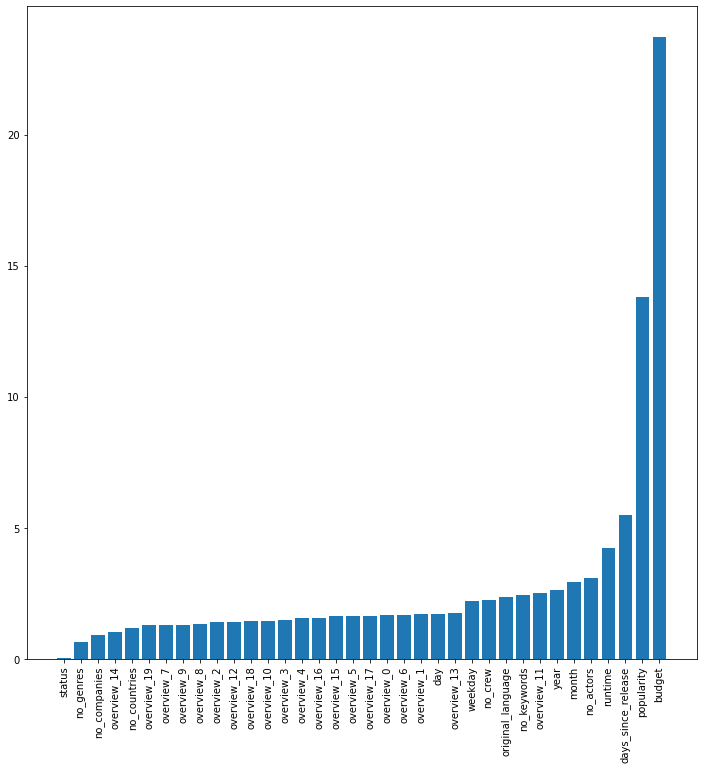

In [ ]:
#Plot made by training a model on only first 36 features
imp = feature_imps.mean(axis=1)
imps, names = zip(*sorted(zip(imp, train.columns)))

plt.figure(figsize=(12,12))
plt.bar(names,imps)
plt.xticks(rotation=90)
plt.show()

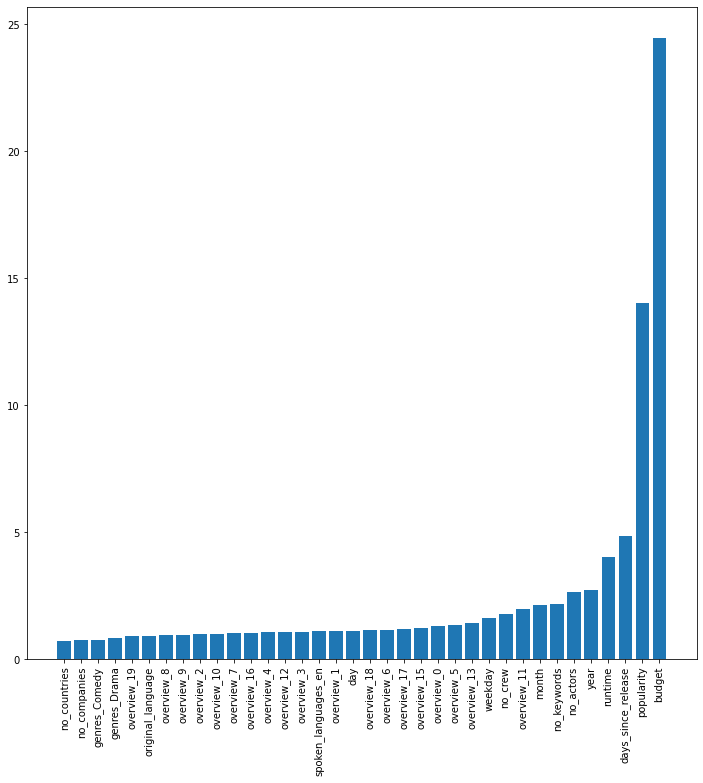

In [ ]:
#Plot made by training a model on all features
imp = feature_imps.mean(axis=1)
imps, names = zip(*sorted(zip(imp, train.columns)))

plt.figure(figsize=(12,12))
plt.bar(names[-36:],imps[-36:])
plt.xticks(rotation=90)
plt.show()